# Import libraries

In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import fiona
import geopandas as gpd
import momepy
from shapely.geometry import LineString
from shapely.geometry import Point
# Set the option to display all columns
pd.options.display.max_columns = None
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
import rasterio
from pyproj import Transformer
import os
import re

import warnings
# Suppress specific warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Import data

In [43]:
gdb_path = "D:\GIS\HCI\HCI.gdb"
layers = fiona.listlayers(gdb_path)
print("Layers:", layers)

Layers: ['Lee_Health_hospital_XYTableToPoint', 'wastewater_facilities_arcgis_XYTableToPoint', 'LeeCountyBoundary_Polygon', 'Hosted_Building_Office_Medical', 'Lee_Health', 'Lee_Health_hospital', 'Lee_Power_Point', 'Florida_Power_Line', 'Lee_Power_Point_Plants', 'Lee_Power_Point_Substations', 'Lee_Power_Line', 'Lee_Power_Line_Clip', 'Lee_Health_hospital_nodes', 'Lee_Communication', 'Lee_Communication_Tower']


## Lee County

In [44]:
lee_county = gpd.read_file(gdb_path, layer='LeeCountyBoundary_Polygon')
target_crs = "EPSG:3087"
lee_county = lee_county.to_crs(target_crs)

In [45]:
# lee county as bounding box
minx, miny, maxx, maxy = lee_county.total_bounds

x_padding = (maxx - minx) * 0.02
y_padding = (maxy - miny) * 0.02

global_xlim = (minx - x_padding, maxx + x_padding)
global_ylim = (miny - y_padding, maxy + y_padding)

## Hospital

In [46]:
hospital_raw = gpd.read_file(gdb_path, layer='Lee_Health_hospital_nodes')
hospital_raw

,BldgDataSo,FolioID,STRAP,ParcelBldg,BuildingKe,SubCondoNa,CondoBldgN,AddressNo,StreetName,AddressBld,StreetAddr,PostalCity,PostalCode,BldgUseTyp,BldgDescri,BasemapCla,Residentia,MaxStories,ActualArea,EffectiveA,ActualYear,EffectiveY,EstimatedV,ValueSourc,ModifyDate,ModifiedBy,GlobalID,created_us,created_da,last_edite,last_edi_1,ORIG_FID,geometry
0,LeePA Building Footprints,10221123,044624030000B0000,2,285149,HEALTHPARK FLORIDA WEST,,,,,,,,OFFICE/MEDICAL,Hospital,Medical,0,7.0,411299,352122,2017,2017,164282519.0,Depreciated Value,2017-10-27 00:00:00+00:00,HOSKISSONB,760cdc5b-b8bd-40f6-af01-0c06ab30fab6,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,1,POINT (607735.525 279783.827)
1,LeePA Building Footprints,10554317,19452528000000020,1,253199,GULF COAST MEDICAL CENTER,,13681,DOCTORS WAY,,13681 DOCTORS WAY,FORT MYERS,33912,OFFICE/MEDICAL,Hospital,Medical,1,4.0,741488,722427,1990,2006,220906618.0,Depreciated Value,2020-04-02 00:00:00+00:00,HOSKISSONB,fdcf759e-b575-4a3e-9c7a-4ec48bae2248,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,2,POINT (613817 283988.324)
2,LeePA Building Footprints,10221123,044624030000B0000,1,120200,HEALTHPARK FLORIDA WEST,,9981,SOUTH HEALTHPARK DR,,9981 SOUTH HEALTHPARK DR,FORT MYERS,33908,OFFICE/MEDICAL,Hospital,Medical,0,8.0,704752,659458,1991,2010,243928239.0,Depreciated Value,2017-10-27 00:00:00+00:00,HOSKISSONB,3617087f-8ca4-4a9b-b8c4-ef8d3ff4489a,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,3,POINT (607629.543 279809.163)
3,LeePA Building Footprints,10172610,234424P3020130010,1,89042,EDISON PARK,,2776,CLEVELAND AVE,,2776 CLEVELAND AVE,FORT MYERS,33901,OFFICE/MEDICAL,Hospital,Medical,0,8.0,326031,316145,1967,1990,78207950.0,Depreciated Value,2019-07-10 00:00:00+00:00,HOSKISSONB,67458aaa-d3f5-4988-b392-4a28bc659938,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,4,POINT (611286.048 293324.612)
4,LeePA Building Footprints,10167861,184424C3000020000,1,85868,CAPE CORAL UNIT 1824,,636,DEL PRADO BLVD S,,636 DEL PRADO BLVD S,CAPE CORAL,33990,OFFICE/MEDICAL,Hospital,Medical,0,5.0,513489,494850,1976,1997,114040162.0,Depreciated Value,2025-01-07 00:00:00+00:00,HOSKISSONB,afd68383-59d2-47be-9ff0-adaaf9c7dfee,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,5,POINT (604469.657 294418.295)


In [47]:
hospital = hospital_raw.drop(index=2)
hospital

,BldgDataSo,FolioID,STRAP,ParcelBldg,BuildingKe,SubCondoNa,CondoBldgN,AddressNo,StreetName,AddressBld,StreetAddr,PostalCity,PostalCode,BldgUseTyp,BldgDescri,BasemapCla,Residentia,MaxStories,ActualArea,EffectiveA,ActualYear,EffectiveY,EstimatedV,ValueSourc,ModifyDate,ModifiedBy,GlobalID,created_us,created_da,last_edite,last_edi_1,ORIG_FID,geometry
0,LeePA Building Footprints,10221123,044624030000B0000,2,285149,HEALTHPARK FLORIDA WEST,,,,,,,,OFFICE/MEDICAL,Hospital,Medical,0,7.0,411299,352122,2017,2017,164282519.0,Depreciated Value,2017-10-27 00:00:00+00:00,HOSKISSONB,760cdc5b-b8bd-40f6-af01-0c06ab30fab6,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,1,POINT (607735.525 279783.827)
1,LeePA Building Footprints,10554317,19452528000000020,1,253199,GULF COAST MEDICAL CENTER,,13681,DOCTORS WAY,,13681 DOCTORS WAY,FORT MYERS,33912,OFFICE/MEDICAL,Hospital,Medical,1,4.0,741488,722427,1990,2006,220906618.0,Depreciated Value,2020-04-02 00:00:00+00:00,HOSKISSONB,fdcf759e-b575-4a3e-9c7a-4ec48bae2248,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,2,POINT (613817 283988.324)
3,LeePA Building Footprints,10172610,234424P3020130010,1,89042,EDISON PARK,,2776,CLEVELAND AVE,,2776 CLEVELAND AVE,FORT MYERS,33901,OFFICE/MEDICAL,Hospital,Medical,0,8.0,326031,316145,1967,1990,78207950.0,Depreciated Value,2019-07-10 00:00:00+00:00,HOSKISSONB,67458aaa-d3f5-4988-b392-4a28bc659938,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,4,POINT (611286.048 293324.612)
4,LeePA Building Footprints,10167861,184424C3000020000,1,85868,CAPE CORAL UNIT 1824,,636,DEL PRADO BLVD S,,636 DEL PRADO BLVD S,CAPE CORAL,33990,OFFICE/MEDICAL,Hospital,Medical,0,5.0,513489,494850,1976,1997,114040162.0,Depreciated Value,2025-01-07 00:00:00+00:00,HOSKISSONB,afd68383-59d2-47be-9ff0-adaaf9c7dfee,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,5,POINT (604469.657 294418.295)


In [48]:
hospital.crs

<Projected CRS: EPSG:3087>
Name: NAD83(HARN) / Florida GDL Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Florida.
- bounds: (-87.63, 24.41, -79.97, 31.01)
Coordinate Operation:
- name: Florida GDL Albers (meter)
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
# Ensure hospitals have a unique ID
if 'Hospital_ID' not in hospital.columns:
    hospital['Hospital_ID'] = 'Hosp_' + hospital.index.astype(str)

hospital

,BldgDataSo,FolioID,STRAP,ParcelBldg,BuildingKe,SubCondoNa,CondoBldgN,AddressNo,StreetName,AddressBld,StreetAddr,PostalCity,PostalCode,BldgUseTyp,BldgDescri,BasemapCla,Residentia,MaxStories,ActualArea,EffectiveA,ActualYear,EffectiveY,EstimatedV,ValueSourc,ModifyDate,ModifiedBy,GlobalID,created_us,created_da,last_edite,last_edi_1,ORIG_FID,geometry,Hospital_ID
0,LeePA Building Footprints,10221123,044624030000B0000,2,285149,HEALTHPARK FLORIDA WEST,,,,,,,,OFFICE/MEDICAL,Hospital,Medical,0,7.0,411299,352122,2017,2017,164282519.0,Depreciated Value,2017-10-27 00:00:00+00:00,HOSKISSONB,760cdc5b-b8bd-40f6-af01-0c06ab30fab6,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,1,POINT (607735.525 279783.827),Hosp_0
1,LeePA Building Footprints,10554317,19452528000000020,1,253199,GULF COAST MEDICAL CENTER,,13681,DOCTORS WAY,,13681 DOCTORS WAY,FORT MYERS,33912,OFFICE/MEDICAL,Hospital,Medical,1,4.0,741488,722427,1990,2006,220906618.0,Depreciated Value,2020-04-02 00:00:00+00:00,HOSKISSONB,fdcf759e-b575-4a3e-9c7a-4ec48bae2248,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,2,POINT (613817 283988.324),Hosp_1
3,LeePA Building Footprints,10172610,234424P3020130010,1,89042,EDISON PARK,,2776,CLEVELAND AVE,,2776 CLEVELAND AVE,FORT MYERS,33901,OFFICE/MEDICAL,Hospital,Medical,0,8.0,326031,316145,1967,1990,78207950.0,Depreciated Value,2019-07-10 00:00:00+00:00,HOSKISSONB,67458aaa-d3f5-4988-b392-4a28bc659938,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,4,POINT (611286.048 293324.612),Hosp_3
4,LeePA Building Footprints,10167861,184424C3000020000,1,85868,CAPE CORAL UNIT 1824,,636,DEL PRADO BLVD S,,636 DEL PRADO BLVD S,CAPE CORAL,33990,OFFICE/MEDICAL,Hospital,Medical,0,5.0,513489,494850,1976,1997,114040162.0,Depreciated Value,2025-01-07 00:00:00+00:00,HOSKISSONB,afd68383-59d2-47be-9ff0-adaaf9c7dfee,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,5,POINT (604469.657 294418.295),Hosp_4


## Power
Attributes: https://geodata.dep.state.fl.us/datasets/FDEP::critical-infrastructure/about?layer=26

In [50]:
power = gpd.read_file(gdb_path, layer='Lee_Power_Point')
# power = power.set_index('Asset_ID')
print(power.shape)
power.head(5)

(47, 208)


,SEQPLT,YEAR,PSTATABB,PNAME,ORISPL,OPRNAME,OPRCODE,UTLSRVNM,UTLSRVID,SECTOR,BANAME,BACODE,NERC,SUBRGN,SRNAME,ISORTO,FIPSST,FIPSCNTY,CNTYNAME,LAT,LON,CAMDFLAG,NUMUNT,NUMGEN,PLPRMFL,PLFUELCT,COALFLAG,CAPFAC,NAMEPCAP,NBFACTOR,RMBMFLAG,CHPFLAG,USETHRMO,PWRTOHT,ELCALLOC,PSFLAG,PLHTIAN,PLHTIOZ,PLHTIANT,PLHTIOZT,PLNGENAN,PLNGENOZ,PLNOXAN,PLNOXOZ,PLSO2AN,PLCO2AN,PLCH4AN,PLN2OAN,PLCO2EQA,PLHGAN,PLNOXRTA,PLNOXRTO,PLSO2RTA,PLCO2RTA,PLCH4RTA,PLN2ORTA,PLC2ERTA,PLHGRTA,PLNOXRA,PLNOXRO,PLSO2RA,PLCO2RA,PLCH4RA,PLN2ORA,PLC2ERA,PLHGRA,PLNOXCRT,PLNOXCRO,PLSO2CRT,PLCO2CRT,PLCH4CRT,PLN2OCRT,PLC2ECRT,PLHGCRT,UNNOX,UNNOXOZ,UNSO2,UNCO2,UNCH4,UNN2O,UNHG,UNHTI,UNHTIOZ,UNHTIT,UNHTIOZT,UNNOXSRC,UNNOZSRC,UNSO2SRC,UNCO2SRC,UNCH4SRC,UNN2OSRC,UNHGSRC,UNHTISRC,UNHOZSRC,BIONOX,BIONOXOZ,BIOSO2,BIOCO2,BIOCH4,BION2O,CHPCHTI,CHPCHTIOZ,CHPNOX,CHPNOXOZ,CHPSO2,CHPCO2,CHPCH4,CHPN2O,PLHTRT,PLGENACL,PLGENAOL,PLGENAGS,PLGENANC,PLGENAHY,PLGENABM,PLGENAWI,PLGENASO,PLGENAGT,PLGENAOF,PLGENAOP,PLGENATN,PLGENATR,PLGENATH,PLGENACY,PLGENACN,PLCLPR,PLOLPR,PLGSPR,PLNCPR,PLHYPR,PLBMPR,PLWIPR,PLSOPR,PLGTPR,PLOFPR,PLOPPR,PLTNPR,PLTRPR,PLTHPR,PLCYPR,PLCNPR,Name,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,OBJECTID_1,ID,CITY,STATE,ZIP,TYPE,STATUS,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,LINES,MAX_VOLT,MIN_VOLT,MAX_INFER,MIN_INFER,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry
0,2548.0,2021.0,FL,Fort Myers,612.0,Florida Power & Light Co,6452.0,Florida Power & Light Co,6452.0,Electric Utility,Florida Power & Light Company,FPL,SERC,FRCC,FRCC All,,12,071,Lee,26.696700,-81.783100,Yes,10.0,14.0,NG,GAS,,0.41907,2680.9,0.634887,,,0.0,0.0,0.0,,6.932228e+07,3.314536e+07,6.932228e+07,3.314536e+07,9841677.0,4818740.0,963.061,463.215,23.370,4122017.181,157566.293,15832.609,4126345.818,,0.196,0.192,0.005,837.666,0.016,0.002,838.545,,0.028,0.028,0.001,118.923,0.002,0.000,119.048,,0.196,0.192,0.005,837.666,0.016,0.002,838.545,,963.061,463.215,23.370,4122017.181,157566.293,15832.609,,6.932228e+07,3.314536e+07,6.932228e+07,3.314536e+07,EPA/CAMD,EPA/CAMD,EPA/CAMD,EPA/CAMD,EIA,EIA,--,EPA/CAMD,EPA/CAMD,,,,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7043.746237,0.0,10193.222,9831483.78,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,9841677.002,0.00,0.00,9841677.002,0.0,0.0,0.001036,0.998964,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,1.0000,0.0000,0.0000,1.0,0.0,Fort Myers,0.0,Florida Power & Light Co,FloridaPowerPlantsFrom_eGRID_EPA_XY,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,ELC_PT_000064,,Lee,South Florida Water Management District,EPA,FloridaPowerPlantsFrom_eGRID_EPA_XY,,,,0,,,,,,,,,0.000000,0.000000,,,,1899-12-30 00:00:00+00:00,,1899-12-30 00:00:00+00:00,0.0,0.0,0.0,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,POINT (620184.943 301057.056)
1,2593.0,2021.0,FL,Lee County Solid Waste Energy,52010.0,Florida Power & Light Co,6452.0,Lee County Board-Commissioners,10875.0,IPP Non-CHP,Florida Power & Light Company,FPL,SERC,FRCC,FRCC All,,12,071,Lee,26.631549,-81.760656,,3.0,2.0,MSW,BIOMASS,,0.63352,59.0,0.277468,Yes,,0.0,0.0,0.0,,5.764773e+06,2.538736e+06,5.764773e+06,2.538736e+06,327428.0,141203.0,604.995,278.614,49.747,317613.306,406674.966,53379.028,330650.218,,3.695,3.946,0.304,1940.050,1.242,0.163,2019.682,,0.210,0.219,0.017,110.191,0.071,0.009,114.714,,3.695,3.946,0.304,1940.050,1.242,0.163,2019.682,,604.995,278.614,49.747,576061.990,406674.966,53379.028,,5.764773e+06,2

In [51]:
power = power.set_crs(target_crs, allow_override=True)

In [52]:
power['Asset'].unique()

array(['FloridaPowerPlantsFrom_eGRID_EPA_XY', 'DHS HIFLD - Substations'],
      dtype=object)

In [53]:
power['Water_Mana'].unique()

array(['South Florida Water Management District'], dtype=object)

In [54]:
power.crs

<Projected CRS: EPSG:3087>
Name: NAD83(HARN) / Florida GDL Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Florida.
- bounds: (-87.63, 24.41, -79.97, 31.01)
Coordinate Operation:
- name: Florida GDL Albers (meter)
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [55]:
plants = power[power['Asset'] == 'FloridaPowerPlantsFrom_eGRID_EPA_XY'].copy()
substations = power[power['Asset'] == 'DHS HIFLD - Substations'].copy()
print(f"The number of plants: {len(plants)}, the number of substations: {len(substations)}")

The number of plants: 2, the number of substations: 45


In [56]:
transmission = gpd.read_file(gdb_path, layer='Lee_Power_Line_Clip')
print(transmission.shape)
transmission.head(2)

(82, 63)


,OBJECTID_1,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,Name,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,Shape_Length,geometry
0,1396,142542,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-01-07 00:00:00+00:00,IMAGERY,2017-05-18 00:00:00+00:00,FLORIDA POWER & LIGHT CO,230.0,220-287,Y,UNKNOWN108623,ORANGE RIVER,4583.544128,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_1396,,Lee,South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,High,High,High,High,High,High,High,High,High,High,Not Affected,Not Affected,Not Affected,Not Affected,High,High,4085.983815,"MULTILINESTRING ((621650.957 298446.21, 621568..."
1,3441,145119,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2016-11-10 00:00:00+00:00,IMAGERY/OTHER,2019-03-19 00:00:00+00:00,FLORIDA POWER & LIGHT CO,138.0,100-161,Y,FORT MYERS,TAP151595,2588.099105,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_3441,Fort Myers,Lee,South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,High,High,High,High,High,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,2309.539377,"MULTILINESTRING ((612113.349 294840.332, 61212..."


In [57]:
transmission['Asset_ID']

0      EPSF_PL_1396
1      EPSF_PL_3441
2      EPSF_PL_8083
3     EPSF_PL_12110
4     EPSF_PL_12111
          ...      
77    EPSF_PL_42795
78     EPSF_PL_1396
79     EPSF_PL_8265
80     EPSF_PL_8265
81    EPSF_PL_34145
Name: Asset_ID, Length: 82, dtype: object

In [58]:
substations.crs

<Projected CRS: EPSG:3087>
Name: NAD83(HARN) / Florida GDL Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Florida.
- bounds: (-87.63, 24.41, -79.97, 31.01)
Coordinate Operation:
- name: Florida GDL Albers (meter)
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [59]:
transmission.crs

<Projected CRS: EPSG:3087>
Name: NAD83(HARN) / Florida GDL Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Florida.
- bounds: (-87.63, 24.41, -79.97, 31.01)
Coordinate Operation:
- name: Florida GDL Albers (meter)
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Power network based on lines

In [60]:
transmission.head()

,OBJECTID_1,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,Name,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,Shape_Length,geometry
0,1396,142542,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-01-07 00:00:00+00:00,IMAGERY,2017-05-18 00:00:00+00:00,FLORIDA POWER & LIGHT CO,230.0,220-287,Y,UNKNOWN108623,ORANGE RIVER,4583.544128,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_1396,,Lee,South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,High,High,High,High,High,High,High,High,High,High,Not Affected,Not Affected,Not Affected,Not Affected,High,High,4085.983815,"MULTILINESTRING ((621650.957 298446.21, 621568..."
1,3441,145119,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2016-11-10 00:00:00+00:00,IMAGERY/OTHER,2019-03-19 00:00:00+00:00,FLORIDA POWER & LIGHT CO,138.0,100-161,Y,FORT MYERS,TAP151595,2588.099105,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_3441,Fort Myers,Lee,South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,High,High,High,High,High,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,2309.539377,"MULTILINESTRING ((612113.349 294840.332, 61212..."
2,8265,156062,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2017-10-17 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,FLORIDA POWER & LIGHT CO,230.0,220-287,N,HERCULES,FORT MYERS SWITCHYARD,23859.001479,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_8083,,"Lee, Charlotte",South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,9065.862683,"MULTILINESTRING ((620456.24 301334.677, 620483..."
3,12110,107179,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.cape-coral-daily-breeze.co...",2016-11-10 00:00:00+00:00,IMAGERY/OTHER,2019-03-19 00:00:00+00:00,FLORIDA POWER & LIGHT CO,138.0,100-161,N,SOUTH CAPE,CAPE CORAL,4081.702044,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_12110,Cape Coral,Lee,South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,79,33,Medium,Medium,Medium,High,High,High,High,High,High,

In [61]:
transmission['SUB_1'].unique()

array(['UNKNOWN108623', 'FORT MYERS', 'HERCULES', 'SOUTH CAPE', 'EVEREST',
       'AQUALINDA', 'TROPIC ISLE', 'NORTH TRAIL', 'CAPE NORTH', 'CORBETT',
       'WEST CAPE', 'PINEY ROAD', 'LEE', 'ORANGE RIVER', 'CHARLOTTE',
       'CALUSA', 'ALICO', 'TAP141796', 'TAP141795', 'HANSON', 'ESTERO',
       'TAP141798', 'UNKNOWN108485', 'TAP151591', 'LCEC NO. 5',
       'LEE COUNTY SOLID WASTE ENERGY', 'SAN CARLOS', 'CORKSCREW',
       'INDUSTRIAL', 'COLONIAL', 'TAP153225', 'ANDYTOWN', 'BUCKINGHAM',
       'COLLIER', 'BONITA SPRINGS', 'TAP151595', 'UNKNOWN120571',
       'TAP151592', 'TAP152014', 'TAP155021', 'SLATER'], dtype=object)

In [62]:
transmission['SUB_2'].unique()

array(['ORANGE RIVER', 'TAP151595', 'FORT MYERS SWITCHYARD', 'CAPE CORAL',
       'INDUSTRIAL', 'TAP151592', 'WEST CAPE', 'TAP151594', 'LEE',
       'CAPE NORTH', 'RISER151593', 'TAP151591', 'LIVINGSTON', 'JETPORT',
       'GATEWAY', 'IMPERIAL', 'PINE ISLAND', 'TAP152014', 'TAP155021',
       'BUCKINGHAM', 'ALVA', 'TERRY', 'CALUSA', 'ORANGETREE', 'ESTERO',
       'TROPIC ISLE', 'SAN CARLOS', 'CORKSCREW', 'TAP154083', 'TAP153225',
       'TAP151589', 'NOT AVAILABLE', 'EDISON', 'TAP167094',
       'DEADEND167093', 'DEADEND167096', 'DEADEND167101'], dtype=object)

In [63]:
mask_sub1 = (
    (transmission['SUB_1'] != 'NOT AVAILABLE') & 
    (~transmission['SUB_1'].str.startswith('UNKNOWN'))
)

mask_sub2 = (
    (transmission['SUB_2'] != 'NOT AVAILABLE') & 
    (~transmission['SUB_2'].str.startswith('UNKNOWN'))
)

mask_no_loop = (transmission['SUB_1'] != transmission['SUB_2'])

valid_transmission = transmission[mask_sub1 & mask_sub2 & mask_no_loop].copy()

print(f"Valid: {len(valid_transmission)}")
print(f"Removed: {len(transmission) - len(valid_transmission)}")

Valid: 76
Removed: 6


In [64]:
valid_transmission['sorted_edge'] = valid_transmission.apply(
    lambda row: tuple(sorted([row['SUB_1'], row['SUB_2']])), axis=1
)

# keep the line with the highest voltage (e.g., keeping 500kV over 138kV for the same link)
valid_transmission = valid_transmission.sort_values(by='VOLTAGE', ascending=False)

valid_transmission_dedup = valid_transmission.drop_duplicates(subset=['sorted_edge'])

print(f"Final row count after deduplication: {len(valid_transmission_dedup)}")
print(f"Removed {len(valid_transmission) - len(valid_transmission_dedup)} duplicate/parallel lines")

valid_transmission = valid_transmission_dedup.copy()

Final row count after deduplication: 67
Removed 9 duplicate/parallel lines


In [65]:
type(valid_transmission)

geopandas.geodataframe.GeoDataFrame

In [66]:
valid_transmission.head(2)

,OBJECTID_1,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,Name,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,Shape_Length,geometry,sorted_edge
52,42601,131048,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.psc.state.f...",2015-01-07 00:00:00+00:00,IMAGERY,2015-09-30 00:00:00+00:00,FLORIDA POWER & LIGHT CO,500.0,500,N,ANDYTOWN,ORANGE RIVER,192298.845435,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_1396,"Weston, Southwest Ranches, Fort Myers","Lee, Collier, Hendry, Broward, Palm Beach",South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,"Southwest Florida, Treasure Coast, South Florida","South District, Southeast District","Southwest, Southeast",1,77,26,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,High,High,High,High,High,High,High,High,High,High,Not Affected,Not Affected,Not Affected,Not Affected,High,High,31799.206830,"MULTILINESTRING ((621650.957 298446.21, 621737...","(ANDYTOWN, ORANGE RIVER)"
2,8265,156062,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2017-10-17 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,FLORIDA POWER & LIGHT CO,230.0,220-287,N,HERCULES,FORT MYERS SWITCHYARD,23859.001479,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,0.0,FLORIDA POWER & LIGHT CO,AC; OVERHEAD,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,EPSF_PL_8083,,"Lee, Charlotte",South Florida Water Management District,DHS-HIFLD,DHS HIFLD - Electric_Power_Transmission_Lines,,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,9065.862683,"MULTILINESTRING ((620456.24 301334.677, 620483...","(FORT MYERS SWITCHYARD, HERCULES)"


In [67]:
from shapely.ops import linemerge

valid_transmission['edge_type'] = 'power_transmission'
G = nx.from_pandas_edgelist(
    valid_transmission,
    source='SUB_1', 
    target='SUB_2', 
    edge_attr=['VOLTAGE', 'edge_type'],
    create_using=nx.DiGraph()
    # create_using=nx.Graph()
)

# add nodes attributes
nx.set_node_attributes(G, 'substations', 'type')

pos_dict = {}
def get_coords(geom):
    if geom.geom_type == "MultiLineString":
        merged = linemerge(geom)
        # linemerge can return LineString OR MultiLineString if not connectable
        if merged.geom_type == "LineString":
            return merged.coords[0], merged.coords[-1]
        else:
            # disconnected: no single ordered path exists
            raise ValueError("MultiLineString is disconnected; cannot define single start/end.")
    elif geom.geom_type == "LineString":
        return geom.coords[0], geom.coords[-1]
    else:
        raise TypeError(f"Unsupported geometry type: {geom.geom_type}")

# for idx, row in valid_transmission.iterrows():
#     s, e = get_coords(row.geometry)
#     pos_dict[row['SUB_1']] = s
#     pos_dict[row['SUB_2']] = e

# nx.set_node_attributes(G, pos_dict, name='pos')

# from collections import defaultdict
# import numpy as np

# coord_accumulator = defaultdict(list)

# for _, row in valid_transmission.iterrows():
#     s, e = get_coords(row.geometry)
#     coord_accumulator[row["SUB_1"]].append(s)
#     coord_accumulator[row["SUB_2"]].append(e)

# pos_dict = {
#     n: tuple(np.mean(coords, axis=0))
#     for n, coords in coord_accumulator.items()
# }

# nx.set_node_attributes(G, pos_dict, "pos")

from collections import defaultdict
import numpy as np

coord_acc = defaultdict(list)

for _, row in valid_transmission.iterrows():
    s, e = get_coords(row.geometry)

    # orientation-free: if a node is incident to this line, it can be at either endpoint
    coord_acc[row["SUB_1"]].append(s)
    coord_acc[row["SUB_1"]].append(e)
    coord_acc[row["SUB_2"]].append(s)
    coord_acc[row["SUB_2"]].append(e)

pos_dict = {
    n: tuple(np.median(np.array(coords), axis=0))
    for n, coords in coord_acc.items()
}

nx.set_node_attributes(G, pos_dict, "pos")

print(f"Power network: {len(G.nodes)} nodes, {len(G.edges)} edges")

Power network: 57 nodes, 67 edges


In [68]:
sample_node = list(G.nodes)[0]
print(f"Node {sample_node} Attribute: {G.nodes[sample_node]}")
# df_edges = nx.to_pandas_edgelist(G)
# df_edges

Node ANDYTOWN Attribute: {'type': 'substations', 'pos': (np.float64(632024.1681999993), np.float64(289317.37665))}


In [69]:
# extract nodes
pos = {}

# process MultiLineString
def get_start_end_coords(geom):
    if geom.geom_type == 'MultiLineString':
        start = geom.geoms[0].coords[0]
        end = geom.geoms[-1].coords[-1]
    else:
        start = geom.coords[0]
        end = geom.coords[-1]
    return start, end

for idx, row in valid_transmission.iterrows():
    start_coords, end_coords = get_start_end_coords(row.geometry)
    
    # SUB_1
    s_node = row['SUB_1']
    if s_node not in pos:
        pos[s_node] = (start_coords[0], start_coords[1])
    
    # SUB_2
    t_node = row['SUB_2']
    if t_node not in pos:
        pos[t_node] = (end_coords[0], end_coords[1])

print(f"{len(pos)} nodes")

57 nodes


In [70]:
valid_transmission['VOLTAGE'].unique()

array([500., 230., 138.])

In [71]:
voltages = sorted([v for v in valid_transmission['VOLTAGE'].unique() if v > 0])
cmap = cm.get_cmap('Greens', len(voltages)+1)
voltage_colors = {v: cmap(i+1) for i, v in enumerate(voltages)}
print(f"Voltages: {voltages}")

Voltages: [np.float64(138.0), np.float64(230.0), np.float64(500.0)]


C:\Users\hai\AppData\Local\Temp\ipykernel_37248\3376360155.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Greens', len(voltages)+1)


In [72]:
pos = nx.get_node_attributes(G, "pos")

same_pos_edges = []
missing_pos_edges = []

for u, v in G.edges():
    if u not in pos or v not in pos:
        missing_pos_edges.append((u, v))
        continue
    if pos[u] == pos[v]:
        same_pos_edges.append((u, v))

print("edges missing pos:", len(missing_pos_edges))
print("edges with identical endpoint positions:", len(same_pos_edges))
print("example same-pos edges:", same_pos_edges[:10])


edges missing pos: 0
edges with identical endpoint positions: 0
example same-pos edges: []


In [73]:
recip = []
E = set(G.edges())
for (u, v) in E:
    if (v, u) in E and u < v:
        recip.append((u, v))

print("reciprocal pairs:", len(recip))
print("example:", recip[:10])

reciprocal pairs: 0
example: []


In [74]:
# Plot-space "loops": different nodes but identical coordinates
pos = nx.get_node_attributes(G, "pos")
same_pos_edges = [(u, v) for u, v in G.edges() if pos[u] == pos[v]]
print("edges with identical endpoint positions:", len(same_pos_edges))
print("examples:", same_pos_edges[:20])

edges with identical endpoint positions: 0
examples: []


1.38
2.3
5.0


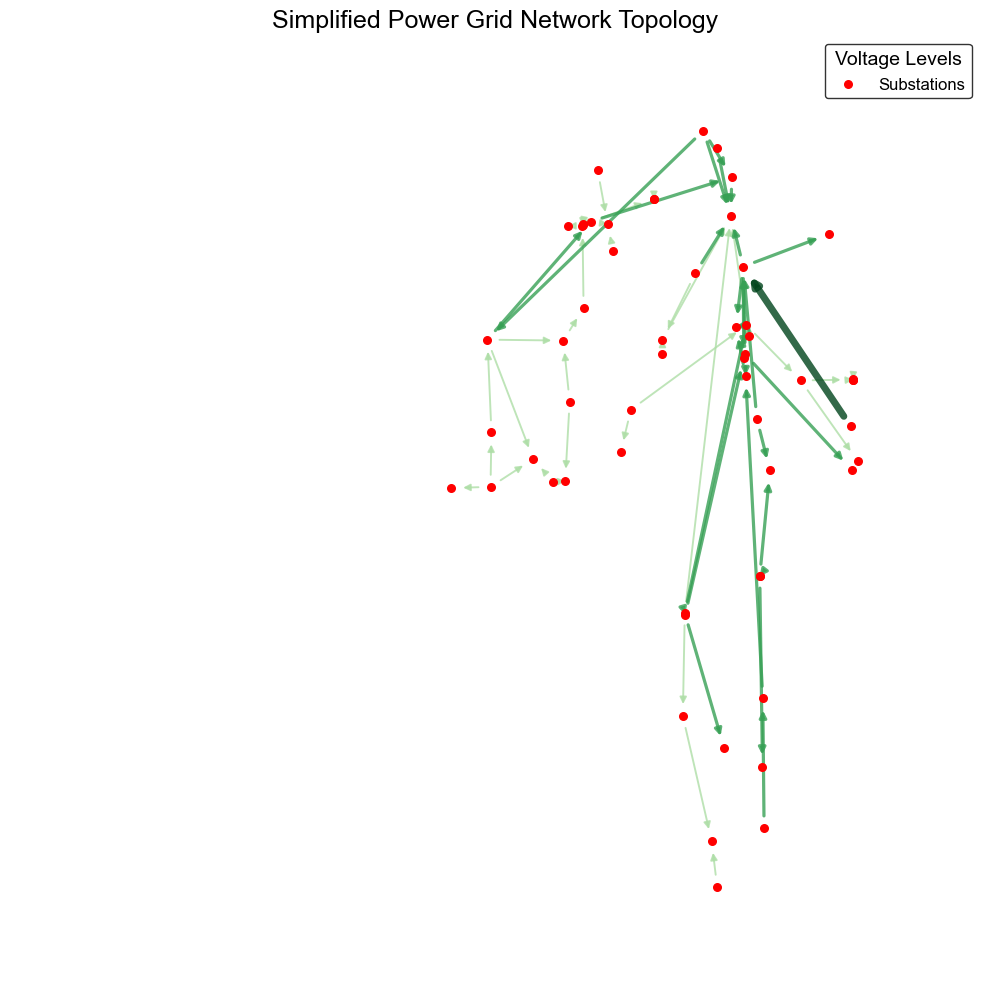

In [75]:
plt.figure(figsize=(10, 10))

valid_nodes = [n for n in G.nodes if n in pos]
nx.draw_networkx_nodes(
    G, pos, 
    nodelist=valid_nodes,
    node_size=30,
    node_color='red',
    label='Substations'
)

for volt in voltages:
    edgelist = [
        (u, v) for u, v, d in G.edges(data=True) 
        if d.get('VOLTAGE') == volt
    ]
    
    current_width = volt / 100
    print(current_width)
    if edgelist:
        nx.draw_networkx_edges(
            G, pos, 
            edgelist=edgelist,
            width=current_width,
            edge_color=[voltage_colors[volt]],
            alpha=0.8,
            label=f"{int(volt)} kV"
        )
        # if current_width == 5.0:
        #     print(edgelist)

plt.title("Simplified Power Grid Network Topology", fontsize=18)
plt.axis('off')

plt.legend(
    loc='upper right', 
    title="Voltage Levels", 
    fontsize=12, 
    title_fontsize=14,
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

plt.xlim(global_xlim)
plt.ylim(global_ylim)

plt.tight_layout()
plt.show()

For a node $v$:
- in-degree: number of edges coming into the node, $u$ -> $v$
- out-degree: number of edges leaving the node, $v$ -> $u$
- Nodes with in-degree = 0: Power sources, or Boundary effects
- Nodes with large out-degree: power plants, high-voltage substation

In [76]:
deg_df = pd.DataFrame({
    "node": list(G.nodes()),
    "in_degree":  [G.in_degree(n)  for n in G.nodes()],
    "out_degree": [G.out_degree(n) for n in G.nodes()],
    "total_degree": [G.degree(n) for n in G.nodes()]
})

deg_df


,node,in_degree,out_degree,total_degree
0,ANDYTOWN,0,1,1
1,ORANGE RIVER,3,4,7
2,HERCULES,0,1,1
3,FORT MYERS SWITCHYARD,8,0,8
4,LEE,2,4,6
5,CALUSA,2,1,3
6,TAP141798,0,3,3
7,ORANGETREE,1,0,1
8,TAP141796,0,3,3
9,LIVINGSTON,1,0,1


In [77]:
VALID_VOLTAGES = {138, 230, 500}

def add_node_voltage_attributes(
    G,
    voltage_attr="VOLTAGE"
):
    for n in G.nodes():
        voltages = []

        # incoming edges
        for _, _, data in G.in_edges(n, data=True):
            v = data.get(voltage_attr)
            if v in VALID_VOLTAGES:
                voltages.append(v)

        # outgoing edges
        for _, _, data in G.out_edges(n, data=True):
            v = data.get(voltage_attr)
            if v in VALID_VOLTAGES:
                voltages.append(v)

        if len(voltages) == 0:
            G.nodes[n]["node_voltage_max"] = None
            G.nodes[n]["node_voltage_min"] = None
            G.nodes[n]["node_voltage_levels"] = []
            G.nodes[n]["is_transformer"] = False
        else:
            vset = sorted(set(voltages))
            G.nodes[n]["node_voltage_max"] = max(vset)
            G.nodes[n]["node_voltage_min"] = min(vset)
            G.nodes[n]["node_voltage_levels"] = vset
            G.nodes[n]["is_transformer"] = len(vset) > 1


In [78]:
add_node_voltage_attributes(G)

In [79]:
def add_directed_degree_attributes(G, add_role=True):
    """
    Adds node attributes:
      - in_degree
      - out_degree
      - total_degree  (in + out)

    Optionally adds:
      - role: source/sink/transit/isolated
    """
    in_deg = dict(G.in_degree())
    out_deg = dict(G.out_degree())

    for n in G.nodes():
        i = in_deg.get(n, 0)
        o = out_deg.get(n, 0)

        G.nodes[n]["in_degree"] = int(i)
        G.nodes[n]["out_degree"] = int(o)
        G.nodes[n]["total_degree"] = int(i + o)

        if add_role:
            if i == 0 and o == 0:
                role = "isolated"
            elif i == 0 and o > 0:
                role = "source"
            elif o == 0 and i > 0:
                role = "sink"
            else:
                role = "transit"
            G.nodes[n]["role"] = role

In [80]:
add_directed_degree_attributes(G)

- find substations with in_degree=0 to link to plants

In [81]:
list(G.predecessors("TAP152014"))

['TAP141798', 'CORKSCREW']

In [82]:
list(G.predecessors("TAP167094"))

['ORANGE RIVER', 'TAP152014', 'BUCKINGHAM']

In [83]:
list(G.predecessors("ORANGE RIVER"))

['ANDYTOWN', 'TAP141795', 'TAP141798']

In [84]:
node_data = dict(G.nodes(data=True))
df_nodes = pd.DataFrame.from_dict(node_data, orient='index')
df_nodes = df_nodes.reset_index().rename(columns={'index': 'Node_ID'})
df_nodes

,Node_ID,type,pos,node_voltage_max,node_voltage_min,node_voltage_levels,is_transformer,in_degree,out_degree,total_degree,role
0,ANDYTOWN,substations,"(632024.1681999993, 289317.37665)",500.0,500.0,[500.0],False,0,1,1,source
1,ORANGE RIVER,substations,"(621650.9567999989, 298446.2098000003)",500.0,230.0,"[230.0, 500.0]",True,3,4,7,transit
2,HERCULES,substations,"(619151.39855, 305229.30544999987)",230.0,230.0,[230.0],False,0,1,1,source
3,FORT MYERS SWITCHYARD,substations,"(620456.2397999987, 301334.6765999999)",230.0,138.0,"[138.0, 230.0]",True,8,0,8,sink
4,LEE,substations,"(606890.7074999996, 301013.86849999987)",230.0,138.0,"[138.0, 230.0]",True,2,4,6,transit
5,CALUSA,substations,"(620537.1318999995, 303553.11569999997)",230.0,230.0,[230.0],False,2,1,3,transit
6,TAP141798,substations,"(621846.0711000003, 293422.78780000005)",230.0,230.0,[230.0],False,0,3,3,source
7,ORANGETREE,substations,"(632120.3520500008, 286845.3683500001)",230.0,230.0,[230.0],False,1,0,1,sink
8,TAP141796,substations,"(623245.7162999995, 280755.1646999996)",230.0,230.0,[230.0],False,0,3,3,source
9,LIVINGSTON,substations,"(623510.5547499992, 269852.6722499998)",230.0,230.0,[230.0],False,1,0,1,sink


In [85]:
df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,VOLTAGE,edge_type
0,ANDYTOWN,ORANGE RIVER,500.0,power_transmission
1,ORANGE RIVER,FORT MYERS SWITCHYARD,230.0,power_transmission
2,ORANGE RIVER,GATEWAY,230.0,power_transmission
3,ORANGE RIVER,TAP167094,230.0,power_transmission
4,ORANGE RIVER,ALVA,230.0,power_transmission
...,...,...,...,...
62,COLONIAL,BUCKINGHAM,138.0,power_transmission
63,COLONIAL,EDISON,138.0,power_transmission
64,TAP153225,TAP155021,138.0,power_transmission
65,TAP153225,TAP154083,138.0,power_transmission


### Connect plants to substations (nearest)

Lines Bounds: 
[589607.9197 258950.1798 642397.3796 309123.9343]
Nodes Bounds: 
[620184.9426 293865.9384 622545.1954 301057.0563]


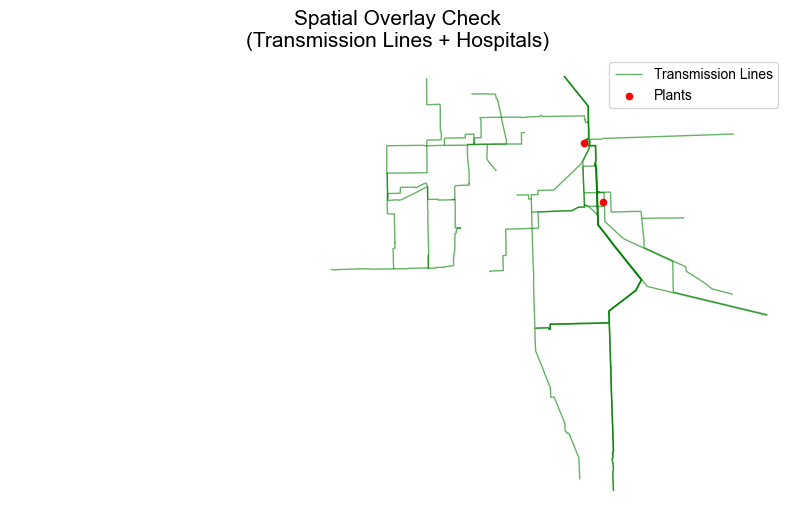

In [86]:
target_crs = 3087
lines_viz = valid_transmission.to_crs(epsg=target_crs)
nodes_viz = plants.to_crs(epsg=target_crs)

print(f"Lines Bounds: \n{lines_viz.total_bounds}")
print(f"Nodes Bounds: \n{nodes_viz.total_bounds}")

fig, ax = plt.subplots(figsize=(10, 10))

lines_viz.plot(
    ax=ax, 
    color='green', 
    linewidth=1, 
    alpha=0.6, 
    label='Transmission Lines'
)

nodes_viz.plot(
    ax=ax, 
    color='red', 
    marker='o',
    markersize=20, 
    label='Plants',
    zorder=5
)

plt.xlim(global_xlim)
plt.ylim(global_ylim)

plt.title("Spatial Overlay Check\n(Transmission Lines + Hospitals)", fontsize=15)
plt.legend()
plt.axis('off')
plt.show()

In [87]:
G_power = G.copy()
len(G_power.nodes)

57

In [88]:
plants

,SEQPLT,YEAR,PSTATABB,PNAME,ORISPL,OPRNAME,OPRCODE,UTLSRVNM,UTLSRVID,SECTOR,BANAME,BACODE,NERC,SUBRGN,SRNAME,ISORTO,FIPSST,FIPSCNTY,CNTYNAME,LAT,LON,CAMDFLAG,NUMUNT,NUMGEN,PLPRMFL,PLFUELCT,COALFLAG,CAPFAC,NAMEPCAP,NBFACTOR,RMBMFLAG,CHPFLAG,USETHRMO,PWRTOHT,ELCALLOC,PSFLAG,PLHTIAN,PLHTIOZ,PLHTIANT,PLHTIOZT,PLNGENAN,PLNGENOZ,PLNOXAN,PLNOXOZ,PLSO2AN,PLCO2AN,PLCH4AN,PLN2OAN,PLCO2EQA,PLHGAN,PLNOXRTA,PLNOXRTO,PLSO2RTA,PLCO2RTA,PLCH4RTA,PLN2ORTA,PLC2ERTA,PLHGRTA,PLNOXRA,PLNOXRO,PLSO2RA,PLCO2RA,PLCH4RA,PLN2ORA,PLC2ERA,PLHGRA,PLNOXCRT,PLNOXCRO,PLSO2CRT,PLCO2CRT,PLCH4CRT,PLN2OCRT,PLC2ECRT,PLHGCRT,UNNOX,UNNOXOZ,UNSO2,UNCO2,UNCH4,UNN2O,UNHG,UNHTI,UNHTIOZ,UNHTIT,UNHTIOZT,UNNOXSRC,UNNOZSRC,UNSO2SRC,UNCO2SRC,UNCH4SRC,UNN2OSRC,UNHGSRC,UNHTISRC,UNHOZSRC,BIONOX,BIONOXOZ,BIOSO2,BIOCO2,BIOCH4,BION2O,CHPCHTI,CHPCHTIOZ,CHPNOX,CHPNOXOZ,CHPSO2,CHPCO2,CHPCH4,CHPN2O,PLHTRT,PLGENACL,PLGENAOL,PLGENAGS,PLGENANC,PLGENAHY,PLGENABM,PLGENAWI,PLGENASO,PLGENAGT,PLGENAOF,PLGENAOP,PLGENATN,PLGENATR,PLGENATH,PLGENACY,PLGENACN,PLCLPR,PLOLPR,PLGSPR,PLNCPR,PLHYPR,PLBMPR,PLWIPR,PLSOPR,PLGTPR,PLOFPR,PLOPPR,PLTNPR,PLTRPR,PLTHPR,PLCYPR,PLCNPR,Name,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,OBJECTID_1,ID,CITY,STATE,ZIP,TYPE,STATUS,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,LINES,MAX_VOLT,MIN_VOLT,MAX_INFER,MIN_INFER,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry
0,2548.0,2021.0,FL,Fort Myers,612.0,Florida Power & Light Co,6452.0,Florida Power & Light Co,6452.0,Electric Utility,Florida Power & Light Company,FPL,SERC,FRCC,FRCC All,,12,071,Lee,26.696700,-81.783100,Yes,10.0,14.0,NG,GAS,,0.41907,2680.9,0.634887,,,0.0,0.0,0.0,,6.932228e+07,3.314536e+07,6.932228e+07,3.314536e+07,9841677.0,4818740.0,963.061,463.215,23.370,4122017.181,157566.293,15832.609,4126345.818,,0.196,0.192,0.005,837.666,0.016,0.002,838.545,,0.028,0.028,0.001,118.923,0.002,0.000,119.048,,0.196,0.192,0.005,837.666,0.016,0.002,838.545,,963.061,463.215,23.370,4122017.181,157566.293,15832.609,,6.932228e+07,3.314536e+07,6.932228e+07,3.314536e+07,EPA/CAMD,EPA/CAMD,EPA/CAMD,EPA/CAMD,EIA,EIA,--,EPA/CAMD,EPA/CAMD,,,,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7043.746237,0.0,10193.222,9831483.78,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,9841677.002,0.00,0.00,9841677.002,0.0,0.0,0.001036,0.998964,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,1.0000,0.0000,0.0000,1.0,0.0,Fort Myers,0.0,Florida Power & Light Co,FloridaPowerPlantsFrom_eGRID_EPA_XY,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,ELC_PT_000064,,Lee,South Florida Water Management District,EPA,FloridaPowerPlantsFrom_eGRID_EPA_XY,,,,0,,,,,,,,,0.0,0.0,,,,1899-12-30 00:00:00+00:00,,1899-12-30 00:00:00+00:00,0.0,0.0,0.0,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,POINT (620184.943 301057.056)
1,2593.0,2021.0,FL,Lee County Solid Waste Energy,52010.0,Florida Power & Light Co,6452.0,Lee County Board-Commissioners,10875.0,IPP Non-CHP,Florida Power & Light Company,FPL,SERC,FRCC,FRCC All,,12,071,Lee,26.631549,-81.760656,,3.0,2.0,MSW,BIOMASS,,0.63352,59.0,0.277468,Yes,,0.0,0.0,0.0,,5.764773e+06,2.538736e+06,5.764773e+06,2.538736e+06,327428.0,141203.0,604.995,278.614,49.747,317613.306,406674.966,53379.028,330650.218,,3.695,3.946,0.304,1940.050,1.242,0.163,2019.682,,0.210,0.219,0.017,110.191,0.071,0.009,114.714,,3.695,3.946,0.304,1940.050,1.242,0.163,2019.682,,604.995,278.614,49.747,576061.990,406674.966,53379.028,,5.764773e+06,2.538736e+0

In [89]:
# find the targets which can connect to the hospital
sub_candidates = valid_transmission[['SUB_2', 'geometry']].copy()
def get_endpoint(geom):
    if geom.geom_type == 'MultiLineString':
        return Point(geom.geoms[-1].coords[-1])
    else:
        return Point(geom.coords[-1])
    
sub_candidates['geometry'] = sub_candidates['geometry'].apply(get_endpoint)
sub_candidates

,SUB_2,geometry
52,ORANGE RIVER,POINT (642397.38 280188.543)
2,FORT MYERS SWITCHYARD,POINT (617846.557 309123.934)
40,CALUSA,POINT (606890.707 301013.868)
41,ORANGETREE,POINT (642394.633 280267.949)
17,FORT MYERS SWITCHYARD,POINT (620456.24 301334.677)
...,...,...
66,TAP151589,POINT (606890.707 301013.868)
63,TAP154083,POINT (638216.635 282731.775)
64,TAP153225,POINT (627200.433 291940.201)
77,TAP151589,POINT (613015.468 302303.048)


In [90]:
# drop duplicates
gdf_source = sub_candidates.drop_duplicates(subset=['SUB_2']).rename(columns={'SUB_2': 'source_id'})
gdf_source.shape

(36, 2)

In [91]:
# hospitals as targets
gdf_target = plants.copy()

# connect to the nearest substation
joined = gpd.sjoin_nearest(
    gdf_target,
    gdf_source,
    how='left',
    distance_col='dist'
)

joined

,SEQPLT,YEAR,PSTATABB,PNAME,ORISPL,OPRNAME,OPRCODE,UTLSRVNM,UTLSRVID,SECTOR,BANAME,BACODE,NERC,SUBRGN,SRNAME,ISORTO,FIPSST,FIPSCNTY,CNTYNAME,LAT,LON,CAMDFLAG,NUMUNT,NUMGEN,PLPRMFL,PLFUELCT,COALFLAG,CAPFAC,NAMEPCAP,NBFACTOR,RMBMFLAG,CHPFLAG,USETHRMO,PWRTOHT,ELCALLOC,PSFLAG,PLHTIAN,PLHTIOZ,PLHTIANT,PLHTIOZT,PLNGENAN,PLNGENOZ,PLNOXAN,PLNOXOZ,PLSO2AN,PLCO2AN,PLCH4AN,PLN2OAN,PLCO2EQA,PLHGAN,PLNOXRTA,PLNOXRTO,PLSO2RTA,PLCO2RTA,PLCH4RTA,PLN2ORTA,PLC2ERTA,PLHGRTA,PLNOXRA,PLNOXRO,PLSO2RA,PLCO2RA,PLCH4RA,PLN2ORA,PLC2ERA,PLHGRA,PLNOXCRT,PLNOXCRO,PLSO2CRT,PLCO2CRT,PLCH4CRT,PLN2OCRT,PLC2ECRT,PLHGCRT,UNNOX,UNNOXOZ,UNSO2,UNCO2,UNCH4,UNN2O,UNHG,UNHTI,UNHTIOZ,UNHTIT,UNHTIOZT,UNNOXSRC,UNNOZSRC,UNSO2SRC,UNCO2SRC,UNCH4SRC,UNN2OSRC,UNHGSRC,UNHTISRC,UNHOZSRC,BIONOX,BIONOXOZ,BIOSO2,BIOCO2,BIOCH4,BION2O,CHPCHTI,CHPCHTIOZ,CHPNOX,CHPNOXOZ,CHPSO2,CHPCO2,CHPCH4,CHPN2O,PLHTRT,PLGENACL,PLGENAOL,PLGENAGS,PLGENANC,PLGENAHY,PLGENABM,PLGENAWI,PLGENASO,PLGENAGT,PLGENAOF,PLGENAOP,PLGENATN,PLGENATR,PLGENATH,PLGENACY,PLGENACN,PLCLPR,PLOLPR,PLGSPR,PLNCPR,PLHYPR,PLBMPR,PLWIPR,PLSOPR,PLGTPR,PLOFPR,PLOPPR,PLTNPR,PLTRPR,PLTHPR,PLCYPR,PLCNPR,Name,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,OBJECTID_1,ID,CITY,STATE,ZIP,TYPE,STATUS,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,LINES,MAX_VOLT,MIN_VOLT,MAX_INFER,MIN_INFER,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry,index_right,source_id,dist
0,2548.0,2021.0,FL,Fort Myers,612.0,Florida Power & Light Co,6452.0,Florida Power & Light Co,6452.0,Electric Utility,Florida Power & Light Company,FPL,SERC,FRCC,FRCC All,,12,071,Lee,26.696700,-81.783100,Yes,10.0,14.0,NG,GAS,,0.41907,2680.9,0.634887,,,0.0,0.0,0.0,,6.932228e+07,3.314536e+07,6.932228e+07,3.314536e+07,9841677.0,4818740.0,963.061,463.215,23.370,4122017.181,157566.293,15832.609,4126345.818,,0.196,0.192,0.005,837.666,0.016,0.002,838.545,,0.028,0.028,0.001,118.923,0.002,0.000,119.048,,0.196,0.192,0.005,837.666,0.016,0.002,838.545,,963.061,463.215,23.370,4122017.181,157566.293,15832.609,,6.932228e+07,3.314536e+07,6.932228e+07,3.314536e+07,EPA/CAMD,EPA/CAMD,EPA/CAMD,EPA/CAMD,EIA,EIA,--,EPA/CAMD,EPA/CAMD,,,,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7043.746237,0.0,10193.222,9831483.78,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,9841677.002,0.00,0.00,9841677.002,0.0,0.0,0.001036,0.998964,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,1.0000,0.0000,0.0000,1.0,0.0,Fort Myers,0.0,Florida Power & Light Co,FloridaPowerPlantsFrom_eGRID_EPA_XY,,Electric Production and Supply Facilities,Critical Infrastructure,Regionally Significant,ELC_PT_000064,,Lee,South Florida Water Management District,EPA,FloridaPowerPlantsFrom_eGRID_EPA_XY,,,,0,,,,,,,,,0.0,0.0,,,,1899-12-30 00:00:00+00:00,,1899-12-30 00:00:00+00:00,0.0,0.0,0.0,,,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,POINT (620184.943 301057.056),70,TAP167094,2994.280729
1,2593.0,2021.0,FL,Lee County Solid Waste Energy,52010.0,Florida Power & Light Co,6452.0,Lee County Board-Commissioners,10875.0,IPP Non-CHP,Florida Power & Light Company,FPL,SERC,FRCC,FRCC All,,12,071,Lee,26.631549,-81.760656,,3.0,2.0,MSW,BIOMASS,,0.63352,59.0,0.277468,Yes,,0.0,0.0,0.0,,5.764773e+06,2.538736e+06,5.764773e+06,2.538736e+06,327428.0,141203.0,604.995,278.614,49.747,317613.306,406674.966,53379.028,330650.218,,3.695,3.946,0.304,1940.050,1.242,0.163,2019.682,,0.210,0.219,0.017,110.191,0.071,0.009,114.714,,3.695,3.946,0.304,1940.050,1.242,0.163,2019.682,,604.995,278.614,49.747,57606

In [92]:
final_links = joined.sort_values('dist').drop_duplicates(subset=['PNAME'])

plant_power_df = pd.DataFrame({
    'source': final_links['PNAME'],   # Plants
    # 'target': final_links['source_id'], # Substations
    'target': ['TAP141796', 'ANDYTOWN'],
    'VOLTAGE': [500.0, 230.0],
    'edge_type': 'plant_power'
})

plant_power_df

,source,target,VOLTAGE,edge_type
1,Lee County Solid Waste Energy,TAP141796,500.0,plant_power
0,Fort Myers,ANDYTOWN,230.0,plant_power


In [93]:
u = "TAP152014"
v = "TAP167094"

print("u in G:", u in G)
print("v in G:", v in G)

u in G: True
v in G: True


u = "TAP152014" ['TAP141798', 'CORKSCREW']
v = "TAP167094" ['ORANGE RIVER', 'TAP152014', 'BUCKINGHAM']

In [94]:
print(list(G.predecessors(u)))
print(list(G.predecessors(v)))

['TAP141798', 'CORKSCREW']
['ORANGE RIVER', 'TAP152014', 'BUCKINGHAM']


In [95]:
for idx, row in plants.iterrows():
    h_id = row['PNAME']
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    G.add_node(h_id, pos=(geom.x, geom.y), type='plants')
    pos[h_id] = (geom.x, geom.y)


count = 0
for idx, row in plant_power_df.iterrows():
    u = row['source'] # plants
    v = row['target'] # substations
    
    # Check if all the nodes are in G
    if u in G and v in G:
        G.add_edge(
            u, v, 
            VOLTAGE=row['VOLTAGE'],   # 138.0
            edge_type=row['edge_type'] # 'plant_power'
        )
        count += 1
    else:
        print(f"Warning: cannot connect {u} -> {v}")

print(f"Have added {count} edges")
print(f"Plant + Power network: {len(G.nodes)} nodes, {len(G.edges)} edges")

Have added 2 edges
Plant + Power network: 59 nodes, 69 edges


### Connect substations to hospitals

Lines Bounds: 
[589607.9197 258950.1798 642397.3796 309123.9343]
Nodes Bounds: 
[604469.657  279783.8271 613816.9998 294418.2952]


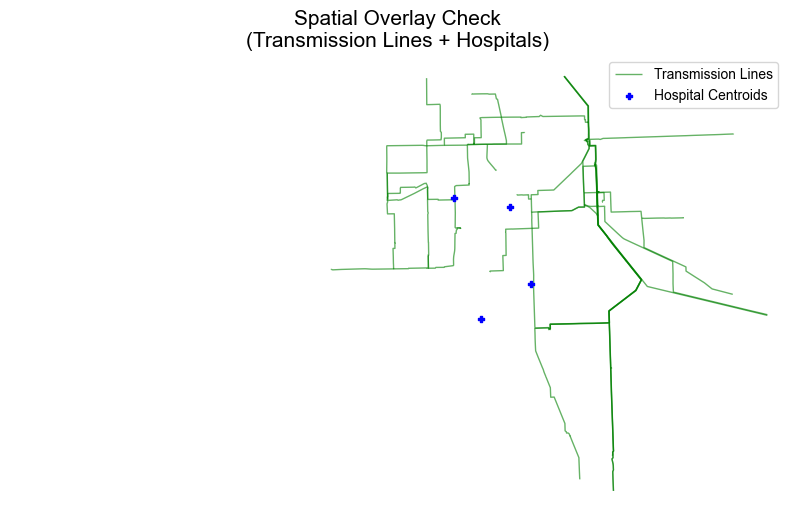

In [96]:
target_crs = 3087
lines_viz = valid_transmission.to_crs(epsg=target_crs)
nodes_viz = hospital.to_crs(epsg=target_crs)

print(f"Lines Bounds: \n{lines_viz.total_bounds}")
print(f"Nodes Bounds: \n{nodes_viz.total_bounds}")

fig, ax = plt.subplots(figsize=(10, 10))

lines_viz.plot(
    ax=ax, 
    color='green', 
    linewidth=1, 
    alpha=0.6, 
    label='Transmission Lines'
)

nodes_viz.plot(
    ax=ax, 
    color='blue', 
    marker='P',
    markersize=20, 
    label='Hospital Centroids',
    zorder=5
)

plt.xlim(global_xlim)
plt.ylim(global_ylim)

plt.title("Spatial Overlay Check\n(Transmission Lines + Hospitals)", fontsize=15)
plt.legend()
plt.axis('off')
plt.show()

In [97]:
G_power = G.copy()
len(G_power.nodes)

59

In [98]:
hospital

,BldgDataSo,FolioID,STRAP,ParcelBldg,BuildingKe,SubCondoNa,CondoBldgN,AddressNo,StreetName,AddressBld,StreetAddr,PostalCity,PostalCode,BldgUseTyp,BldgDescri,BasemapCla,Residentia,MaxStories,ActualArea,EffectiveA,ActualYear,EffectiveY,EstimatedV,ValueSourc,ModifyDate,ModifiedBy,GlobalID,created_us,created_da,last_edite,last_edi_1,ORIG_FID,geometry,Hospital_ID
0,LeePA Building Footprints,10221123,044624030000B0000,2,285149,HEALTHPARK FLORIDA WEST,,,,,,,,OFFICE/MEDICAL,Hospital,Medical,0,7.0,411299,352122,2017,2017,164282519.0,Depreciated Value,2017-10-27 00:00:00+00:00,HOSKISSONB,760cdc5b-b8bd-40f6-af01-0c06ab30fab6,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,1,POINT (607735.525 279783.827),Hosp_0
1,LeePA Building Footprints,10554317,19452528000000020,1,253199,GULF COAST MEDICAL CENTER,,13681,DOCTORS WAY,,13681 DOCTORS WAY,FORT MYERS,33912,OFFICE/MEDICAL,Hospital,Medical,1,4.0,741488,722427,1990,2006,220906618.0,Depreciated Value,2020-04-02 00:00:00+00:00,HOSKISSONB,fdcf759e-b575-4a3e-9c7a-4ec48bae2248,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,2,POINT (613817 283988.324),Hosp_1
3,LeePA Building Footprints,10172610,234424P3020130010,1,89042,EDISON PARK,,2776,CLEVELAND AVE,,2776 CLEVELAND AVE,FORT MYERS,33901,OFFICE/MEDICAL,Hospital,Medical,0,8.0,326031,316145,1967,1990,78207950.0,Depreciated Value,2019-07-10 00:00:00+00:00,HOSKISSONB,67458aaa-d3f5-4988-b392-4a28bc659938,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,4,POINT (611286.048 293324.612),Hosp_3
4,LeePA Building Footprints,10167861,184424C3000020000,1,85868,CAPE CORAL UNIT 1824,,636,DEL PRADO BLVD S,,636 DEL PRADO BLVD S,CAPE CORAL,33990,OFFICE/MEDICAL,Hospital,Medical,0,5.0,513489,494850,1976,1997,114040162.0,Depreciated Value,2025-01-07 00:00:00+00:00,HOSKISSONB,afd68383-59d2-47be-9ff0-adaaf9c7dfee,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,5,POINT (604469.657 294418.295),Hosp_4


In [99]:
# find the targets which can connect to the hospital
sub_candidates = valid_transmission[['SUB_2', 'geometry']].copy()
def get_endpoint(geom):
    if geom.geom_type == 'MultiLineString':
        return Point(geom.geoms[-1].coords[-1])
    else:
        return Point(geom.coords[-1])
    
sub_candidates['geometry'] = sub_candidates['geometry'].apply(get_endpoint)
sub_candidates

,SUB_2,geometry
52,ORANGE RIVER,POINT (642397.38 280188.543)
2,FORT MYERS SWITCHYARD,POINT (617846.557 309123.934)
40,CALUSA,POINT (606890.707 301013.868)
41,ORANGETREE,POINT (642394.633 280267.949)
17,FORT MYERS SWITCHYARD,POINT (620456.24 301334.677)
...,...,...
66,TAP151589,POINT (606890.707 301013.868)
63,TAP154083,POINT (638216.635 282731.775)
64,TAP153225,POINT (627200.433 291940.201)
77,TAP151589,POINT (613015.468 302303.048)


In [100]:
# drop duplicates
# gdf_source = sub_candidates.drop_duplicates(subset=['SUB_2']).rename(columns={'SUB_2': 'source_id'})
# gdf_source.shape

In [101]:
# hospitals as targets
gdf_target = hospital.copy()

# connect to the nearest substation
joined = gpd.sjoin_nearest(
    gdf_target,
    gdf_source,
    how='left',
    distance_col='dist'
)

joined

,BldgDataSo,FolioID,STRAP,ParcelBldg,BuildingKe,SubCondoNa,CondoBldgN,AddressNo,StreetName,AddressBld,StreetAddr,PostalCity,PostalCode,BldgUseTyp,BldgDescri,BasemapCla,Residentia,MaxStories,ActualArea,EffectiveA,ActualYear,EffectiveY,EstimatedV,ValueSourc,ModifyDate,ModifiedBy,GlobalID,created_us,created_da,last_edite,last_edi_1,ORIG_FID,geometry,Hospital_ID,index_right,source_id,dist
0,LeePA Building Footprints,10221123,044624030000B0000,2,285149,HEALTHPARK FLORIDA WEST,,,,,,,,OFFICE/MEDICAL,Hospital,Medical,0,7.0,411299,352122,2017,2017,164282519.0,Depreciated Value,2017-10-27 00:00:00+00:00,HOSKISSONB,760cdc5b-b8bd-40f6-af01-0c06ab30fab6,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,1,POINT (607735.525 279783.827),Hosp_0,69,EDISON,5743.325733
1,LeePA Building Footprints,10554317,19452528000000020,1,253199,GULF COAST MEDICAL CENTER,,13681,DOCTORS WAY,,13681 DOCTORS WAY,FORT MYERS,33912,OFFICE/MEDICAL,Hospital,Medical,1,4.0,741488,722427,1990,2006,220906618.0,Depreciated Value,2020-04-02 00:00:00+00:00,HOSKISSONB,fdcf759e-b575-4a3e-9c7a-4ec48bae2248,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,2,POINT (613817 283988.324),Hosp_1,69,EDISON,5201.041102
3,LeePA Building Footprints,10172610,234424P3020130010,1,89042,EDISON PARK,,2776,CLEVELAND AVE,,2776 CLEVELAND AVE,FORT MYERS,33901,OFFICE/MEDICAL,Hospital,Medical,0,8.0,326031,316145,1967,1990,78207950.0,Depreciated Value,2019-07-10 00:00:00+00:00,HOSKISSONB,67458aaa-d3f5-4988-b392-4a28bc659938,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,4,POINT (611286.048 293324.612),Hosp_3,1,TAP151595,2727.432553
4,LeePA Building Footprints,10167861,184424C3000020000,1,85868,CAPE CORAL UNIT 1824,,636,DEL PRADO BLVD S,,636 DEL PRADO BLVD S,CAPE CORAL,33990,OFFICE/MEDICAL,Hospital,Medical,0,5.0,513489,494850,1976,1997,114040162.0,Depreciated Value,2025-01-07 00:00:00+00:00,HOSKISSONB,afd68383-59d2-47be-9ff0-adaaf9c7dfee,LCGIS,2025-11-18 00:00:00+00:00,LCGIS,2025-11-19 00:00:00+00:00,5,POINT (604469.657 294418.295),Hosp_4,45,TROPIC ISLE,286.333020


In [102]:
final_links = joined.sort_values('dist').drop_duplicates(subset=['Hospital_ID'])

hospital_access_df = pd.DataFrame({
    'source': final_links['source_id'],   # Substations
    'target': final_links['Hospital_ID'], # Hospitals
    'VOLTAGE': 138.0,
    'edge_type': 'power_hospital'
})

hospital_access_df

,source,target,VOLTAGE,edge_type
4,TROPIC ISLE,Hosp_4,138.0,power_hospital
3,TAP151595,Hosp_3,138.0,power_hospital
1,EDISON,Hosp_1,138.0,power_hospital
0,EDISON,Hosp_0,138.0,power_hospital


In [103]:
for idx, row in hospital.iterrows():
    h_id = row['Hospital_ID']
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    G.add_node(h_id, pos=(geom.x, geom.y), type='hospitals')
    pos[h_id] = (geom.x, geom.y)


count = 0
for idx, row in hospital_access_df.iterrows():
    u = row['source'] # substation
    v = row['target'] # Hospital
    
    # Check if all the nodes are in G
    if u in G and v in G:
        G.add_edge(
            u, v, 
            VOLTAGE=row['VOLTAGE'],   # 138.0
            edge_type=row['edge_type'] # 'hospital_access'
        )
        count += 1
    else:
        print(f"Warning: cannot connect {u} -> {v}")

print(f"Have added {count} edges")
print(f"Hospital + Power network: {len(G.nodes)} nodes, {len(G.edges)} edges")

Have added 4 edges
Hospital + Power network: 63 nodes, 73 edges


['Fort Myers', 'Lee County Solid Waste Energy']


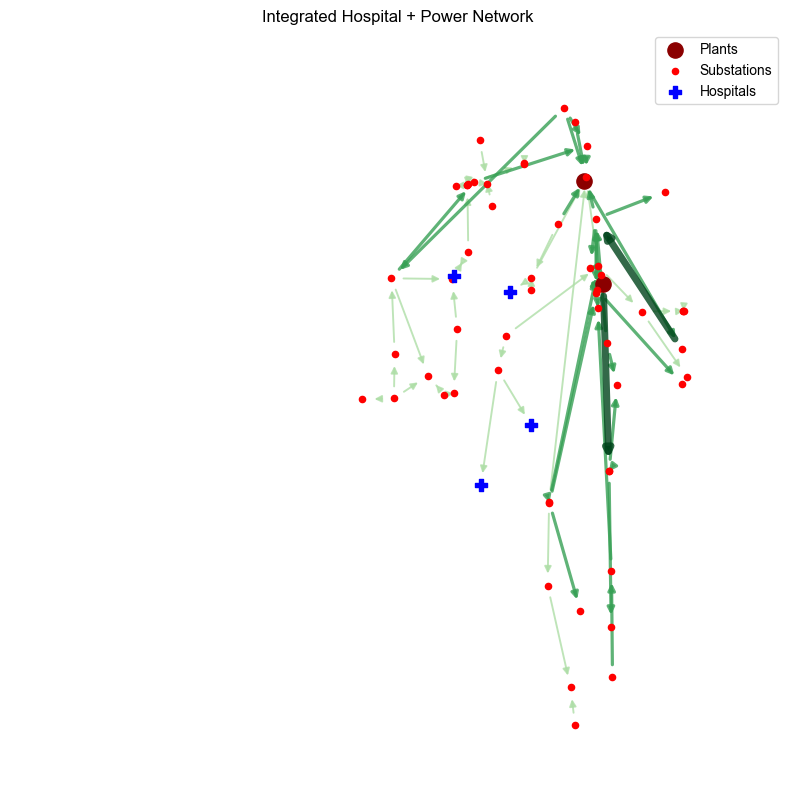

In [104]:
plt.figure(figsize=(10, 10))

# Plants
plant_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'plants']
nx.draw_networkx_nodes(G, pos, nodelist=plant_nodes, node_size=120, node_color='darkred', label='Plants')
print(plant_nodes)

# Substations
sub_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'substations']
sub_nodes = [n for n in sub_nodes if n in pos]
nx.draw_networkx_nodes(G, pos, nodelist=sub_nodes, node_size=20, node_color='red', label='Substations')

# Hospitals
hosp_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'hospitals']
nx.draw_networkx_nodes(G, pos, nodelist=hosp_nodes, node_size=80, node_color='blue', node_shape='P', label='Hospitals')

# Edges
for volt in voltages:
    edgelist = [
        (u, v) for u, v, d in G.edges(data=True) 
        if d.get('VOLTAGE') == volt
    ]
    
    current_width = volt / 100
    if edgelist:
        nx.draw_networkx_edges(
            G, pos, 
            edgelist=edgelist,
            width=current_width,
            edge_color=[voltage_colors[volt]],
            alpha=0.8,
            label=f"{int(volt)} kV"
        )

plt.xlim(global_xlim)
plt.ylim(global_ylim)

plt.legend()
plt.title("Integrated Hospital + Power Network")
plt.axis('off')
plt.show()

In [105]:
node_data = dict(G.nodes(data=True))
df_nodes = pd.DataFrame.from_dict(node_data, orient='index')
df_nodes = df_nodes.reset_index().rename(columns={'index': 'Node_ID'})
df_nodes

,Node_ID,type,pos,node_voltage_max,node_voltage_min,node_voltage_levels,is_transformer,in_degree,out_degree,total_degree,role
0,ANDYTOWN,substations,"(632024.1681999993, 289317.37665)",500.0,500.0,[500.0],False,0.0,1.0,1.0,source
1,ORANGE RIVER,substations,"(621650.9567999989, 298446.2098000003)",500.0,230.0,"[230.0, 500.0]",True,3.0,4.0,7.0,transit
2,HERCULES,substations,"(619151.39855, 305229.30544999987)",230.0,230.0,[230.0],False,0.0,1.0,1.0,source
3,FORT MYERS SWITCHYARD,substations,"(620456.2397999987, 301334.6765999999)",230.0,138.0,"[138.0, 230.0]",True,8.0,0.0,8.0,sink
4,LEE,substations,"(606890.7074999996, 301013.86849999987)",230.0,138.0,"[138.0, 230.0]",True,2.0,4.0,6.0,transit
...,...,...,...,...,...,...,...,...,...,...,...
58,Lee County Solid Waste Energy,plants,"(622545.1953999996, 293865.93840000033)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,Hosp_0,hospitals,"(607735.5247999988, 279783.82710000034)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Hosp_1,hospitals,"(613816.9998000003, 283988.32430000044)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,Hosp_3,hospitals,"(611286.0476000011, 293324.6118999999)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,VOLTAGE,edge_type
0,ANDYTOWN,ORANGE RIVER,500.0,power_transmission
1,ORANGE RIVER,FORT MYERS SWITCHYARD,230.0,power_transmission
2,ORANGE RIVER,GATEWAY,230.0,power_transmission
3,ORANGE RIVER,TAP167094,230.0,power_transmission
4,ORANGE RIVER,ALVA,230.0,power_transmission
...,...,...,...,...
68,EDISON,Hosp_1,138.0,power_hospital
69,EDISON,Hosp_0,138.0,power_hospital
70,SLATER,TAP151589,138.0,power_transmission
71,Fort Myers,ANDYTOWN,230.0,plant_power


In [107]:
print(f"Hospital + Power network: {len(G.nodes)} nodes, {len(G.edges)} edges")

Hospital + Power network: 63 nodes, 73 edges


In [108]:
target_node = 'Hosp_0'
for source, target, attributes in G.edges(target_node, data=True):
    print(f"Target: {target}")
    print(f"Attributes: {attributes}")

In [109]:
target_node = 'EDISON'
for source, target, attributes in G.edges(target_node, data=True):
    print(f"Target: {target}")
    print(f"Attributes: {attributes}")

Target: Hosp_1
Attributes: {'VOLTAGE': 138.0, 'edge_type': 'power_hospital'}
Target: Hosp_0
Attributes: {'VOLTAGE': 138.0, 'edge_type': 'power_hospital'}


## Communication

In [110]:
comm = gpd.read_file(gdb_path, layer='Lee_Communication_Tower')
print(comm.shape)
comm = comm.drop_duplicates(subset="geometry").copy()
print(comm.shape)
comm.head(5)

(205, 78)
(187, 78)


,OBJECTID_1,Permanent_,Source_Fea,Source_Dat,Source_D_1,Source_Ori,Data_Secur,Distributi,LoadDate,FType,FCode,Name,IsLandmark,PointLocat,AdminType,AddressBui,Address,City,State,Zipcode,GNIS_ID,Foot_ID,Complex_ID,OBJECTID__,Ftype_jn,Fcode_jn,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Zip,X,Y,LONGLAT,USNG,OWNERSHIP,PARCELID,FACILITY_T,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry
0,1,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,REYES TREE FARM INC - Verizon Wireless,0,0,0,,8550 NALLE GRADE RD,NORTH FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_000780,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33917,-81.816521,26.753162,"-81.81652112,26.75316168",17R MK 18810 59356,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (616754.888 307264.992)
1,3,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,LEHIGH ACRES JAYCEES INC,0,0,0,,500 SUNSHINE BLVD N,500 SUNSHINE BLVD N,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_000782,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,,-81.683479,26.618303,"-81.68347865,26.61830298",17R MK 31960 44341,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,77,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (630241.787 292537.431)
2,4,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,LEE COUNTY,0,0,0,,11831 BAYSHORE RD,NORTH FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_000783,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33917,-81.763910,26.724133,"-81.76391043,26.72413262",17R MK 24023 56108,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,76,27,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,High,High,High,High,High,High,High,High,High,High,Medium,Medium,Medium,Medium,Medium,Medium,POINT (622035.444 304136.405)
3,5,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FIBERTOWER NETWORK SERVICES CORP.,0,0,0,,2437 SW PINE ISLAND RD,CAPE CORAL,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_000784,Cape Coral,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33991,-82.025300,26.640300,"-82.02530000,26.64030000",17R LK 97949 47005,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,79,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Low,Medium,Medium,Medium,High,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (596231.813 294387.889)
4,7,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,CAPITAL TELECOM,0,0,0,,11941 BONITA BEACH RD SE,Bonita Springs,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_000786,Bonita Springs,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,34135,-81.756100,26

In [111]:
comm.crs

<Projected CRS: EPSG:3087>
Name: NAD83(HARN) / Florida GDL Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Florida.
- bounds: (-87.63, 24.41, -79.97, 31.01)
Coordinate Operation:
- name: Florida GDL Albers (meter)
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [112]:
G_power_hosp = G.copy()
len(G_power_hosp.nodes)

63

In [113]:
comm['Comm_ID'] = 'Comm_' + comm.index.astype(str)
print(f"The number of towers: {len(comm)}")

The number of towers: 187


### Connect towers to hospitals (<3 km)

In [114]:
radius_meters = 3000
hosp_buffer = hospital.copy()
hosp_buffer['geometry'] = hosp_buffer.geometry.buffer(radius_meters)
comm_links = gpd.sjoin(
    comm, 
    hosp_buffer[['geometry', 'Hospital_ID']], 
    how='inner', 
    predicate='within'
)

print(f"Have found {len(comm_links)} communication edges within 3 km")

Have found 34 communication edges within 3 km


In [115]:
print(comm.shape[0])
print(comm_links.shape[0])

187
34


In [116]:
comm_links.head(2)

,OBJECTID_1,Permanent_,Source_Fea,Source_Dat,Source_D_1,Source_Ori,Data_Secur,Distributi,LoadDate,FType,FCode,Name,IsLandmark,PointLocat,AdminType,AddressBui,Address,City,State,Zipcode,GNIS_ID,Foot_ID,Complex_ID,OBJECTID__,Ftype_jn,Fcode_jn,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Zip,X,Y,LONGLAT,USNG,OWNERSHIP,PARCELID,FACILITY_T,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry,Comm_ID,index_right,Hospital_ID
17,2663,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FORT MYERS BROADCASTING COMPANY,0,0,0,,12381 CLEVELAND AVE,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003442,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33907,-81.871500,26.562600,"-81.87150000,26.56260000",17R MK 13199 38285,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (611662.788 286018.028),Comm_17,1,Hosp_1
24,2670,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FORT MYERS FL MAIN HOST CO/OFC,0,0,0,,1520 LEE ST,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003449,Fort Myers,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33901,-81.868139,26.644551,"-81.86813945,26.64455089",17R MK 13596 47360,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,Low,Not Affected,Low,Low,Low,Low,POINT (611839.669 295119.759),Comm_24,3,Hosp_3


In [117]:
hospital_comm_df = pd.DataFrame({
    'source': comm_links['Comm_ID'],   # Substations
    'target': comm_links['Hospital_ID'], # Hospitals
    'edge_type': 'comm_hospital'
})

print(hospital_comm_df.shape)
hospital_comm_df.head()

(34, 3)


,source,target,edge_type
17,Comm_17,Hosp_1,comm_hospital
24,Comm_24,Hosp_3,comm_hospital
32,Comm_32,Hosp_3,comm_hospital
40,Comm_40,Hosp_0,comm_hospital
46,Comm_46,Hosp_0,comm_hospital


In [118]:
G = G_power_hosp.copy()
df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,VOLTAGE,edge_type
0,ANDYTOWN,ORANGE RIVER,500.0,power_transmission
1,ORANGE RIVER,FORT MYERS SWITCHYARD,230.0,power_transmission
2,ORANGE RIVER,GATEWAY,230.0,power_transmission
3,ORANGE RIVER,TAP167094,230.0,power_transmission
4,ORANGE RIVER,ALVA,230.0,power_transmission
...,...,...,...,...
68,EDISON,Hosp_1,138.0,power_hospital
69,EDISON,Hosp_0,138.0,power_hospital
70,SLATER,TAP151589,138.0,power_transmission
71,Fort Myers,ANDYTOWN,230.0,plant_power


In [119]:
for idx, row in comm_links.iterrows():
    c_id = row['Comm_ID']
    geom = row.geometry

    G.add_node(
        c_id, 
        pos=(geom.x, geom.y), 
        type='communication'
    )
    pos[c_id] = (geom.x, geom.y)

count = 0
for idx, row in hospital_comm_df.iterrows():
    u = row['source']
    v = row['target']

    G.add_edge(
        u, v, 
        edge_type='comm_hospital'
    )
    count += 1

print(f"Have added {hospital_comm_df} edges")
print(f"Hospital + Power + Comm network: {len(G.nodes)} nodes, {len(G.edges)} edges")


Have added        source  target      edge_type
17    Comm_17  Hosp_1  comm_hospital
24    Comm_24  Hosp_3  comm_hospital
32    Comm_32  Hosp_3  comm_hospital
40    Comm_40  Hosp_0  comm_hospital
46    Comm_46  Hosp_0  comm_hospital
48    Comm_48  Hosp_3  comm_hospital
52    Comm_52  Hosp_3  comm_hospital
55    Comm_55  Hosp_4  comm_hospital
66    Comm_66  Hosp_3  comm_hospital
72    Comm_72  Hosp_1  comm_hospital
83    Comm_83  Hosp_3  comm_hospital
87    Comm_87  Hosp_0  comm_hospital
91    Comm_91  Hosp_0  comm_hospital
93    Comm_93  Hosp_1  comm_hospital
94    Comm_94  Hosp_1  comm_hospital
100  Comm_100  Hosp_4  comm_hospital
117  Comm_117  Hosp_4  comm_hospital
118  Comm_118  Hosp_1  comm_hospital
122  Comm_122  Hosp_3  comm_hospital
124  Comm_124  Hosp_3  comm_hospital
128  Comm_128  Hosp_3  comm_hospital
129  Comm_129  Hosp_4  comm_hospital
135  Comm_135  Hosp_0  comm_hospital
139  Comm_139  Hosp_3  comm_hospital
144  Comm_144  Hosp_1  comm_hospital
146  Comm_146  Hosp_1  comm

In [120]:
df_edges = nx.to_pandas_edgelist(G)
df_edges.head()

,source,target,VOLTAGE,edge_type
0,ANDYTOWN,ORANGE RIVER,500.0,power_transmission
1,ORANGE RIVER,FORT MYERS SWITCHYARD,230.0,power_transmission
2,ORANGE RIVER,GATEWAY,230.0,power_transmission
3,ORANGE RIVER,TAP167094,230.0,power_transmission
4,ORANGE RIVER,ALVA,230.0,power_transmission


['Fort Myers', 'Lee County Solid Waste Energy']


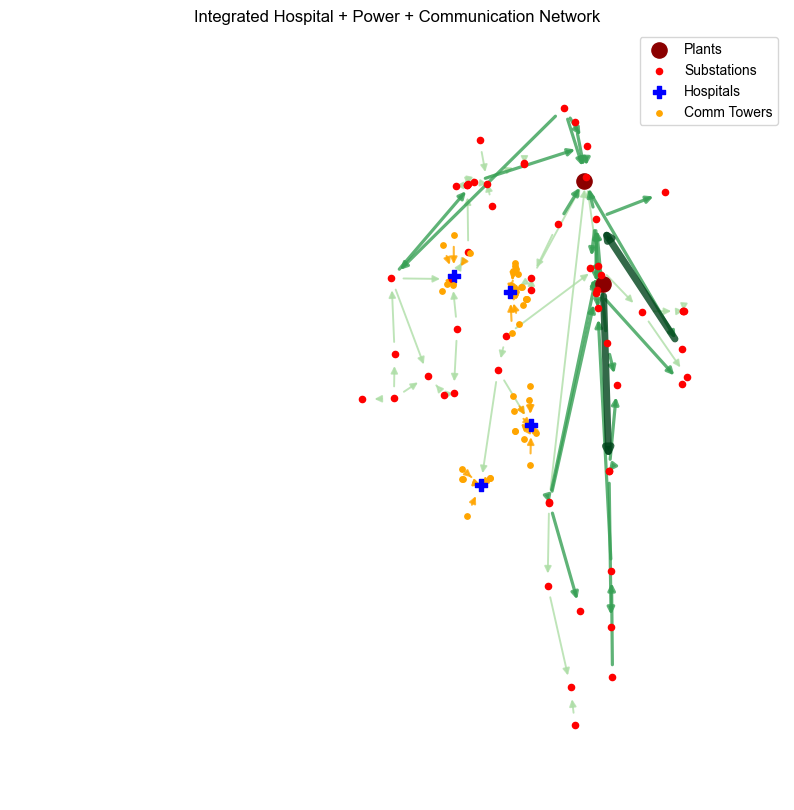

In [121]:
plt.figure(figsize=(10, 10))

# Plants
plant_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'plants']
nx.draw_networkx_nodes(G, pos, nodelist=plant_nodes, node_size=120, node_color='darkred', label='Plants')
print(plant_nodes)

# Substations
sub_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'substations']
sub_nodes = [n for n in sub_nodes if n in pos]
nx.draw_networkx_nodes(G, pos, nodelist=sub_nodes, node_size=20, node_color='red', label='Substations')

# Hospitals
hosp_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'hospitals']
nx.draw_networkx_nodes(G, pos, nodelist=hosp_nodes, node_size=80, node_color='blue', node_shape='P', label='Hospitals')

# Communication powers
comm_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'communication']

# Draw connected nodes
connected_comm = [n for n in comm_nodes if G.degree(n) > 0]
nx.draw_networkx_nodes(G, pos, nodelist=connected_comm, node_size=15, node_color='orange', label='Comm Towers')

# Edges
for volt in voltages:
    edgelist = [
        (u, v) for u, v, d in G.edges(data=True) 
        if d.get('VOLTAGE') == volt
    ]
    
    current_width = volt / 100
    if edgelist:
        nx.draw_networkx_edges(
            G, pos, 
            edgelist=edgelist,
            width=current_width,
            edge_color=[voltage_colors[volt]],
            alpha=0.8,
            label=f"{int(volt)} kV"
        )

comm_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == 'comm_hospital']
if comm_edges:
    nx.draw_networkx_edges(G, pos, edgelist=comm_edges,edge_color='orange', alpha=0.8, width=1.5, label='Comm Link (<3km)')

plt.xlim(global_xlim)
plt.ylim(global_ylim)

plt.legend()
plt.title("Integrated Hospital + Power + Communication Network")
plt.axis('off')
plt.show()

### Connect substations to towers

In [122]:
comm_links.head()

,OBJECTID_1,Permanent_,Source_Fea,Source_Dat,Source_D_1,Source_Ori,Data_Secur,Distributi,LoadDate,FType,FCode,Name,IsLandmark,PointLocat,AdminType,AddressBui,Address,City,State,Zipcode,GNIS_ID,Foot_ID,Complex_ID,OBJECTID__,Ftype_jn,Fcode_jn,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Zip,X,Y,LONGLAT,USNG,OWNERSHIP,PARCELID,FACILITY_T,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry,Comm_ID,index_right,Hospital_ID
17,2663,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FORT MYERS BROADCASTING COMPANY,0,0,0,,12381 CLEVELAND AVE,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003442,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33907,-81.871500,26.562600,"-81.87150000,26.56260000",17R MK 13199 38285,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (611662.788 286018.028),Comm_17,1,Hosp_1
24,2670,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FORT MYERS FL MAIN HOST CO/OFC,0,0,0,,1520 LEE ST,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003449,Fort Myers,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33901,-81.868139,26.644551,"-81.86813945,26.64455089",17R MK 13596 47360,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Medium,Medium,High,High,High,High,High,Low,Not Affected,Low,Low,Low,Low,POINT (611839.669 295119.759),Comm_24,3,Hosp_3
32,2678,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,PREMIERE INTERNATIONAL ASSOC,0,0,0,,2055 CENTRAL AVE,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003457,Fort Myers,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33901,-81.863938,26.639599,"-81.86393794,26.63959894",17R MK 14010 46809,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (612266.647 294577.342),Comm_32,3,Hosp_3
40,2686,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,NEW CINGULAR WIRELESS PCS LLC,0,0,0,,10911 LEECO CT,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003465,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33908,-81.933847,26.511072,"-81.93384733,26.51107152",17R MK 06948 32622,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,High,High,High,High,High,High,High,High,High,High,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (605559.254 280193.433),Comm_40,0,Hosp_0
46,2692,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FLORIDA POWER & LIGHT COMPANY,0,0,0,,15830 WINKLER RD,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003471,,Lee,South Florida Wat

In [123]:
# 1) Clean both frames (drop reserved join columns if present)
reserved = ["index_right", "index_left"]

gdf_target2 = comm_links.drop(columns=[c for c in reserved if c in comm_links.columns]).copy()
gdf_source2 = gdf_source.drop(columns=[c for c in reserved if c in gdf_source.columns]).copy()

# 2) (Recommended) reset target index to avoid weird duplicates
gdf_target2 = gdf_target2.reset_index(drop=True)

# 3) Create a stable ID for one-to-one selection
gdf_target2["_id"] = range(len(gdf_target2))

# 4) Do the join
joined = gpd.sjoin_nearest(
    gdf_target2,
    gdf_source2,
    how="left",
    distance_col="dist"
)

# 5) Enforce one-by-one (one nearest per Comm_ID)
joined_1to1 = (
    joined.sort_values("dist")
          .drop_duplicates(subset="_id", keep="first")
          .drop(columns=["_id"])
)

print("target rows:", gdf_target2.shape[0])
print("joined rows:", joined.shape[0])
print("1-to-1 rows:", joined_1to1.shape[0])
joined_1to1.head()

target rows: 34
joined rows: 36
1-to-1 rows: 34


,OBJECTID_1,Permanent_,Source_Fea,Source_Dat,Source_D_1,Source_Ori,Data_Secur,Distributi,LoadDate,FType,FCode,Name,IsLandmark,PointLocat,AdminType,AddressBui,Address,City,State,Zipcode,GNIS_ID,Foot_ID,Complex_ID,OBJECTID__,Ftype_jn,Fcode_jn,Asset_Elev,Owned_Main,Asset,Asset_Sub_,Asset_Type,Asset_Grou,Asset_Rele,Asset_ID,Municipali,County,Water_Mana,Souce_Data,Souce_Da_1,Source_Ass,Restricted,Notes,Zip,X,Y,LONGLAT,USNG,OWNERSHIP,PARCELID,FACILITY_T,Regional_P,FDEP_Regul,RCP_Region,FDOT_Distr,House_Dist,Senate_Dis,CTF_RL_202,CTF_RL_204,CTF_RL_205,CTF_RL_207,CTF_RL_208,SSF_RL_100,SSF_RL_101,SSF_RL_102,SSF_RL_103,SSF_RL_104,SSF_RL_500,SSF_RL_501,SSF_RL_502,SSF_RL_503,SSF_RL_504,RIF_RL_100,RIF_RL_101,RIF_RL_102,RIF_RL_500,RIF_RL_501,RIF_RL_502,geometry,Comm_ID,Hospital_ID,index_right,source_id,dist
21,2781,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,"OLSEN, ROBERT W",0,0,0,,4461 HANCOCK BRIDGE PKY,NORTH FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003560,,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33903,-81.922569,26.653713,"-81.92256921,26.65371312",17R MK 08186 48413,,09442400010020080,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,76,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Low,Medium,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (606414.453 296044.42),Comm_129,Hosp_4,6,TAP151592,99.678577
7,2701,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,WATERMAN BROADCASTING CORP. OF FLORIDA,0,0,0,,1418 SE 10TH ST,CAPE CORAL,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003480,Cape Coral,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33990,-81.943169,26.633600,"-81.94316885,26.63360019",17R MK 06119 46200,,,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,79,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Low,Medium,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (604405.093 293777.653),Comm_55,Hosp_4,45,TROPIC ISLE,461.414072
32,2837,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,FIBERTOWER NETWORK SERVICES CORP.,0,0,0,,1022 SE 12TH ST,CAPE CORAL,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003616,Cape Coral,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33990,-81.950701,26.634313,"-81.95070093,26.63431268",17R MK 05370 46285,,194424C1007770680,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,79,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Medium,Medium,Medium,High,High,Medium,Medium,Medium,Medium,Medium,Medium,POINT (603655.32 293844.274),Comm_185,Hosp_4,45,TROPIC ISLE,715.311117
5,2694,,,,,,0,,1899-12-30 00:00:00+00:00,0,0,"ALLTEL WIRELESS HOLDINGS, LLC",0,0,0,,2609 DORA ST,FORT MYERS,,,,,,0.0,,,0.0,,Communications - FDEM,,Communications Facilities,Critical infrastructure,Locally Significant,COM_003473,Fort Myers,Lee,South Florida Water Management District,FDEM,Communications - FDEM,,,,33901,-81.859348,26.631101,"-81.85934754,26.63110116",17R MK 14461 45864,,244424P3000130000,RADIO COMMUNICATIONS TOWER,Southwest Florida,South District,Southwest,1,78,33,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,Not Affected,POINT (612739.137 293642.047),Comm_48,Hosp_3,1,TAP151595,1271.014888


In [124]:
joined_1to1['Comm_ID'].nunique()

34

In [125]:
substations_comm_df = pd.DataFrame({
    'source': joined_1to1['source_id'],
    'target': joined_1to1['Comm_ID'],
    'edge_type': 'substation_comm'
})

print(substations_comm_df.shape)
substations_comm_df.head()

(34, 3)


,source,target,edge_type
21,TAP151592,Comm_129,substation_comm
7,TROPIC ISLE,Comm_55,substation_comm
32,TROPIC ISLE,Comm_185,substation_comm
5,TAP151595,Comm_48,substation_comm
27,TAP151595,Comm_159,substation_comm


In [126]:
df_edges = nx.to_pandas_edgelist(G)
df_edges['edge_type'].unique()

array(['power_transmission', 'power_hospital', 'plant_power',
       'comm_hospital'], dtype=object)

In [127]:
count = 0
for idx, row in substations_comm_df.iterrows():
    u = row['source']
    v = row['target']

    G.add_edge(
        u, v, 
        edge_type='substation_comm'
    )
    count += 1

print(f"Have added {substations_comm_df} edges")
print(f"Hospital + Power + Comm network: {len(G.nodes)} nodes, {len(G.edges)} edges")


Have added          source    target        edge_type
21    TAP151592  Comm_129  substation_comm
7   TROPIC ISLE   Comm_55  substation_comm
32  TROPIC ISLE  Comm_185  substation_comm
5     TAP151595   Comm_48  substation_comm
27    TAP151595  Comm_159  substation_comm
30  TROPIC ISLE  Comm_180  substation_comm
10    TAP151595   Comm_83  substation_comm
19    TAP151595  Comm_124  substation_comm
23    TAP151595  Comm_139  substation_comm
2     TAP151595   Comm_32  substation_comm
6     TAP151595   Comm_52  substation_comm
26    TAP151595  Comm_150  substation_comm
1     TAP151595   Comm_24  substation_comm
16    TAP151592  Comm_117  substation_comm
29    TAP151595  Comm_174  substation_comm
8     TAP151595   Comm_66  substation_comm
15  TROPIC ISLE  Comm_100  substation_comm
0        EDISON   Comm_17  substation_comm
28       EDISON  Comm_163  substation_comm
14       ESTERO   Comm_94  substation_comm
18    TAP151595  Comm_122  substation_comm
33       EDISON  Comm_204  substation_comm


['Fort Myers', 'Lee County Solid Waste Energy']


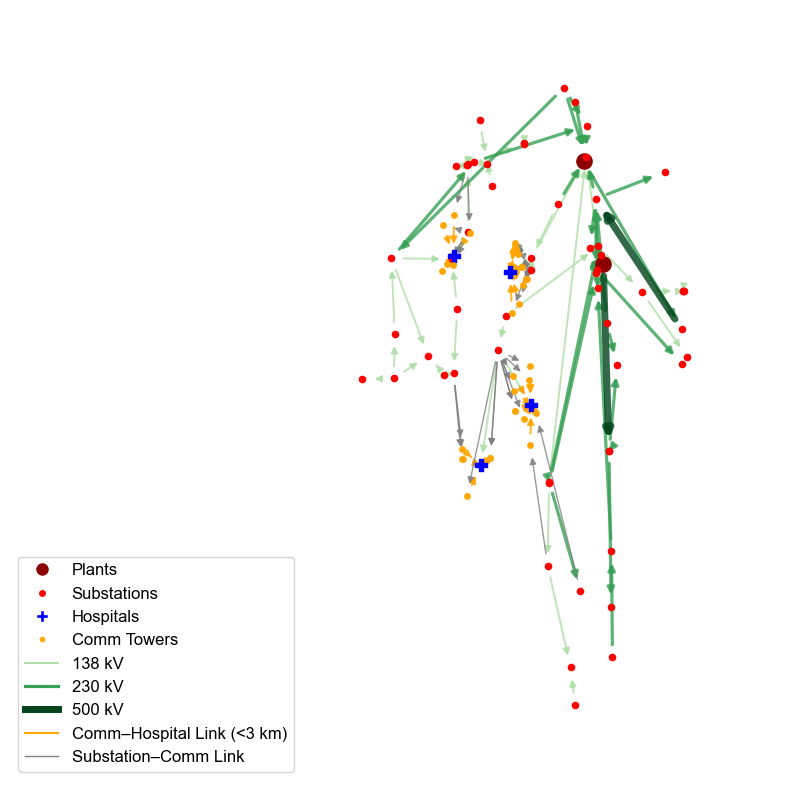

In [128]:
plt.figure(figsize=(10, 10))

# Plants
plant_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'plants']
nx.draw_networkx_nodes(G, pos, nodelist=plant_nodes, node_size=120, node_color='darkred', label='Plants')
print(plant_nodes)

# Substations
sub_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'substations']
sub_nodes = [n for n in sub_nodes if n in pos]
nx.draw_networkx_nodes(G, pos, nodelist=sub_nodes, node_size=20, node_color='red', label='Substations')

# Hospitals
hosp_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'hospitals']
nx.draw_networkx_nodes(G, pos, nodelist=hosp_nodes, node_size=80, node_color='blue', node_shape='P', label='Hospitals')

# Communication powers
comm_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'communication']
nx.draw_networkx_nodes(G, pos, nodelist=comm_nodes, node_size=15, node_color='orange', label='Comm towers')

# Edges
for volt in voltages:
    edgelist = [
        (u, v) for u, v, d in G.edges(data=True) 
        if d.get('VOLTAGE') == volt
    ]
    
    current_width = volt / 100
    if edgelist:
        nx.draw_networkx_edges(
            G, pos, 
            edgelist=edgelist,
            width=current_width,
            edge_color=[voltage_colors[volt]],
            alpha=0.8,
            label=f"{int(volt)} kV"
        )

comm_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == 'comm_hospital']
if comm_edges:
    nx.draw_networkx_edges(G, pos, edgelist=comm_edges,edge_color='orange', alpha=0.8, width=1.5, label='Comm Link (<3km)')

substation_comm_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == 'substation_comm']
if substation_comm_edges:
    nx.draw_networkx_edges(G, pos, edgelist=substation_comm_edges,edge_color='gray', alpha=0.8, width=1.0, label='Substation Comm Link')

plt.xlim(global_xlim)
plt.ylim(global_ylim)

from matplotlib.lines import Line2D

legend_elements = []

# ---- Node legend ----
legend_elements.extend([
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='darkred', markersize=10, label='Plants'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='red', markersize=6, label='Substations'),
    Line2D([0], [0], marker='P', color='w',
           markerfacecolor='blue', markersize=9, label='Hospitals'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='orange', markersize=5, label='Comm Towers'),
])

# ---- Edge legend: voltages ----
for volt in voltages:
    legend_elements.append(
        Line2D([0], [0],
               color=voltage_colors[volt],
               lw=volt / 100,
               label=f"{int(volt)} kV")
    )

# ---- Edge legend: dependency links ----
legend_elements.extend([
    Line2D([0], [0], color='orange', lw=1.5, label='Comm–Hospital Link (<3 km)'),
    Line2D([0], [0], color='gray', lw=1.0, label='Substation–Comm Link'),
])

plt.legend(
    handles=legend_elements,
    loc='lower left',
    frameon=True,
    fontsize=12
)

# plt.title("Integrated Hospital + Power + Communication Network")
plt.axis('off')
plt.show()

## Check the constructed network

In [129]:
node_data = dict(G.nodes(data=True))
df_nodes = pd.DataFrame.from_dict(node_data, orient='index')
df_nodes = df_nodes.reset_index().rename(columns={'index': 'Node_ID'})
df_nodes

,Node_ID,type,pos,node_voltage_max,node_voltage_min,node_voltage_levels,is_transformer,in_degree,out_degree,total_degree,role
0,ANDYTOWN,substations,"(632024.1681999993, 289317.37665)",500.0,500.0,[500.0],False,0.0,1.0,1.0,source
1,ORANGE RIVER,substations,"(621650.9567999989, 298446.2098000003)",500.0,230.0,"[230.0, 500.0]",True,3.0,4.0,7.0,transit
2,HERCULES,substations,"(619151.39855, 305229.30544999987)",230.0,230.0,[230.0],False,0.0,1.0,1.0,source
3,FORT MYERS SWITCHYARD,substations,"(620456.2397999987, 301334.6765999999)",230.0,138.0,"[138.0, 230.0]",True,8.0,0.0,8.0,sink
4,LEE,substations,"(606890.7074999996, 301013.86849999987)",230.0,138.0,"[138.0, 230.0]",True,2.0,4.0,6.0,transit
...,...,...,...,...,...,...,...,...,...,...,...
92,Comm_174,communication,"(611839.4638999999, 295358.3673999999)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,Comm_180,communication,"(603018.3242999986, 293399.4238999998)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,Comm_181,communication,"(605414.1319000013, 280227.46920000017)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Comm_185,communication,"(603655.3198999986, 293844.2737999996)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,VOLTAGE,edge_type
0,ANDYTOWN,ORANGE RIVER,500.0,power_transmission
1,ORANGE RIVER,FORT MYERS SWITCHYARD,230.0,power_transmission
2,ORANGE RIVER,GATEWAY,230.0,power_transmission
3,ORANGE RIVER,TAP167094,230.0,power_transmission
4,ORANGE RIVER,ALVA,230.0,power_transmission
...,...,...,...,...
136,Comm_174,Hosp_3,NaN,comm_hospital
137,Comm_180,Hosp_4,NaN,comm_hospital
138,Comm_181,Hosp_0,NaN,comm_hospital
139,Comm_185,Hosp_4,NaN,comm_hospital


# Topological structure of networks

## Network sumamry (baseline/system-level)

- **Numbers of Nodes and Edges**:
    - **Number of nodes**:
    $$
    N = |V|
    $$

    - **Number of edges**:
    $$
    M = |E|
    $$

- **Network Density**: Network density measures the fraction of realized edges relative to all
possible edges.

    - **Undirected graph**:
    $$
    \rho = \frac{2M}{N(N-1)}
    $$

    - **Directed graph**:
    $$
    \rho = \frac{M}{N(N-1)}
    $$

- **Connected Components**: A connected component is a maximal set of nodes for which a path exists between all node pairs.

    - For **undirected graphs**, standard connected components are used.
    - For **directed graphs**, weakly connected components are used, where edge direction is ignored.

- **Giant Connected Component (GCC)**: The **Giant Connected Component (GCC)** is the largest connected component in the network.

    - **GCC fraction**: This metric indicates the overall connectivity and integrity of the system.
    $$
    \text{GCC}_{\text{frac}} = \frac{|V_{\text{GCC}}|}{N}
    $$


- **Degree-Based Metrics**:
The degree $ k_i $ of node $ i $ is the number of edges incident to it.

    - **Average degree**:
    $$
    \langle k \rangle = \frac{1}{N} \sum_{i=1}^{N} k_i
    $$

    - **Maximum degree**:
    $$
    k_{\max} = \max_i k_i
    $$

- **Shortest-Path Metrics (Computed on GCC)**: Shortest-path-based metrics are computed on the GCC to avoid undefined distances between disconnected node pairs. (Range: $ 0≤E≤1$, $E=1$ means every node connected to every other node. Infrastructure networks ususally have low values.)

    - **Average shortest path length**:
    $$
    L = \frac{1}{|V_{\text{GCC}}|(|V_{\text{GCC}}|-1)}
    \sum_{i \neq j \in V_{\text{GCC}}} d(i,j)
    $$

    - **Network diameter**:
    $$
    D = \max_{i,j \in V_{\text{GCC}}} d(i,j)
    $$

    where $ d(i,j) $ denotes the shortest-path distance between nodes $ i $ and $ j $.

- **Global Efficiency**: Global efficiency measures how efficiently information or resources can be exchanged over the network, even when the graph is disconnected. Pairs of nodes that are not connected contribute zero to the sum. 

$$
E = \frac{1}{N(N-1)} \sum_{i \neq j} \frac{1}{d(i,j)}
$$

- **Clustering Coefficient**:
The local clustering coefficient $ C_i $ measures the tendency of a node’s neighbors to be connected. Let node $ i $ have: degree $k_i$ and neighbor set $N(i)$. Let $e_i$ = number of edges between nodes in $N(i)$.
    - **Local clustering coefficient**:
    $$
    C_i ​= \frac{2e_i}{k_i​(k_i​−1)} (k_i ​≥ 2)
    $$
    if $ k_i < 2$, define:
    $$
    C_i = 0
    $$

    - **Average clustering coefficient**:
    $$
    \bar{C} = \frac{1}{N} \sum_{i=1}^{N} C_i
    $$


In [131]:
len(list(nx.isolates(G)))

0

In [132]:
# sizes = sorted([len(c) for c in nx.connected_components(G)], reverse=True)
# sizes[:10]

In [133]:
import numpy as np
import pandas as pd
import networkx as nx

def summarize_graph(G, name="Graph"):
    is_directed = G.is_directed()
    N, M = G.number_of_nodes(), G.number_of_edges()
    density = nx.density(G)

    # --- Components & GCC ---
    if is_directed:
        comps = list(nx.weakly_connected_components(G))
        gcc_nodes = max(comps, key=len) if comps else set()
        G_gcc = G.subgraph(gcc_nodes).copy()
        n_components = len(comps)
    else:
        comps = list(nx.connected_components(G))
        gcc_nodes = max(comps, key=len) if comps else set()
        G_gcc = G.subgraph(gcc_nodes).copy()
        n_components = len(comps)

    gcc_frac = (len(gcc_nodes) / N) if N else np.nan

    # --- Degree metrics (directed-aware) ---
    if is_directed:
        indeg = np.array([d for _, d in G.in_degree()])
        outdeg = np.array([d for _, d in G.out_degree()])
        totdeg = np.array([d for _, d in G.degree()])
    else:
        indeg = outdeg = None
        totdeg = np.array([d for _, d in G.degree()])

    # --- Path metrics ---
    # (A) Undirected path metrics on GCC (common + stable)
    if G_gcc.number_of_nodes() >= 2 and nx.is_connected(G_gcc.to_undirected()):
        avg_path_und = nx.average_shortest_path_length(G_gcc.to_undirected())
        diam_und = nx.diameter(G_gcc.to_undirected())
    else:
        avg_path_und, diam_und = np.nan, np.nan

    # (B) Directed path metrics on LSCC (only meaningful place for directed shortest paths)
    if is_directed:
        sccs = list(nx.strongly_connected_components(G))
        lscc_nodes = max(sccs, key=len) if sccs else set()
        G_lscc = G.subgraph(lscc_nodes).copy()
        lscc_frac = (len(lscc_nodes) / N) if N else np.nan

        if G_lscc.number_of_nodes() >= 2:
            # In a strongly connected digraph, directed shortest paths exist for all pairs
            avg_path_dir = nx.average_shortest_path_length(G_lscc)
            # diameter for directed graphs exists in NetworkX; this works on strongly connected digraphs
            diam_dir = nx.diameter(G_lscc)
        else:
            avg_path_dir, diam_dir = np.nan, np.nan
    else:
        lscc_frac, avg_path_dir, diam_dir = np.nan, np.nan, np.nan

    # --- Efficiency ---
    # global_efficiency is defined for undirected graphs in NetworkX
    eff_und = nx.global_efficiency(G.to_undirected()) if N else np.nan

    # --- Clustering ---
    try:
        if is_directed:
            avg_clust_dir = float(np.mean(list(nx.clustering(G).values()))) if N else np.nan
        else:
            avg_clust_dir = np.nan
    except Exception:
        avg_clust_dir = np.nan

    avg_clust_und = nx.average_clustering(G.to_undirected()) if N else np.nan

    # --- Assemble summary ---
    out = {
        "name": name,
        "is_directed": is_directed,
        "N_nodes": N,
        "M_edges": M,
        "density": density,
        "n_weak_components" if is_directed else "n_components": n_components,
        "gcc_frac_weak" if is_directed else "gcc_frac": gcc_frac,

        "avg_degree_total": float(totdeg.mean()) if N else np.nan,
        "max_degree_total": int(totdeg.max()) if N else np.nan,

        # undirected path metrics on GCC
        "avg_path_len_GCC_und": avg_path_und,
        "diameter_GCC_und": diam_und,

        # efficiency computed on undirected version
        "global_efficiency_und": eff_und,

        # clustering
        "avg_clustering_und": avg_clust_und,
    }

    if is_directed:
        out.update({
            "avg_in_degree": float(indeg.mean()) if N else np.nan,
            "max_in_degree": int(indeg.max()) if N else np.nan,
            "avg_out_degree": float(outdeg.mean()) if N else np.nan,
            "max_out_degree": int(outdeg.max()) if N else np.nan,

            "lscc_frac": lscc_frac,
            "avg_path_len_LSCC_dir": avg_path_dir,
            "diameter_LSCC_dir": diam_dir,
            "avg_clustering_dir": avg_clust_dir,
        })

    return out


summary_df = pd.DataFrame([summarize_graph(G, name="Integrated")])
summary_df


,name,is_directed,N_nodes,M_edges,density,n_weak_components,gcc_frac_weak,avg_degree_total,max_degree_total,avg_path_len_GCC_und,diameter_GCC_und,global_efficiency_und,avg_clustering_und,avg_in_degree,max_in_degree,avg_out_degree,max_out_degree,lscc_frac,avg_path_len_LSCC_dir,diameter_LSCC_dir,avg_clustering_dir
0,Integrated,True,97,141,0.015142,1,1.0,2.907216,17,5.183849,10,0.245403,0.323648,1.453608,14,1.453608,15,0.010309,NaN,NaN,0.161824


In [134]:
summary_df.to_csv(r"../output/topo_integrated.csv")

## Ranked critical nodes/edges

- **Node Betweenness Centrality**: measures how frequently a node lies on shortest paths between other node pairs.
- **Edge Betweenness Centrality**: measures how frequently an edge lies on shortest paths between node pairs.
- **Node Closeness Centrality**: measures how close a node is to all other nodes in terms of shortest-path distances.
- **PageRank Centrality**: calculates a node's importance based on the quantity and quality of incoming links.

In [135]:
# Node metrics
deg = dict(G.degree())
bet = nx.betweenness_centrality(G, normalized=True)
clo = nx.closeness_centrality(G)
pr  = nx.pagerank(G)

node_rows = []
for n in G.nodes():
    node_rows.append({
        "node": n,
        "type": G.nodes[n].get("type", None),
        "degree": deg.get(n, 0),
        "betweenness": bet.get(n, 0.0),
        "closeness": clo.get(n, 0.0),
        "pagerank": pr.get(n, 0.0),
    })
nodes_df = pd.DataFrame(node_rows)

print("\nTop-10 by betweenness:")
print(nodes_df.sort_values("betweenness", ascending=False).head(10).to_string(index=False))

# Edge metrics
eb = nx.edge_betweenness_centrality(G, normalized=True)
edges_df = pd.DataFrame([
    {"u": u, "v": v, "etype": G.edges[u, v].get("edge_type", None), "edge_betweenness": val}
    for (u, v), val in eb.items()
])
print("\nTop-10 edges by edge betweenness:")
print(edges_df.sort_values("edge_betweenness", ascending=False).head(10).to_string(index=False))

# Optional exports
# nodes_df.to_csv(r"../output/metrics_nodes.csv", index=False)
# edges_df.to_csv(r"../output/metrics_edges.csv", index=False)


Top-10 by betweenness:
        node        type  degree  betweenness  closeness  pagerank
  CAPE NORTH substations       5     0.005592   0.023438  0.012536
 TROPIC ISLE substations       7     0.005044   0.025000  0.014695
  INDUSTRIAL substations       3     0.004605   0.028935  0.011076
   TAP151592 substations       5     0.003618   0.038580  0.015758
         LEE substations       6     0.003289   0.028935  0.011076
   TAP151595 substations      17     0.003180   0.020833  0.012012
   TAP151591 substations       3     0.001974   0.026786  0.009878
   WEST CAPE substations       2     0.001974   0.010417  0.006776
  BUCKINGHAM substations       6     0.001864   0.031250  0.012910
ORANGE RIVER substations       7     0.001700   0.033333  0.017323

Top-10 edges by edge betweenness:
          u           v              etype  edge_betweenness
 INDUSTRIAL TROPIC ISLE power_transmission          0.005584
  WEST CAPE  CAPE NORTH power_transmission          0.003973
 CAPE NORTH  INDUSTRI

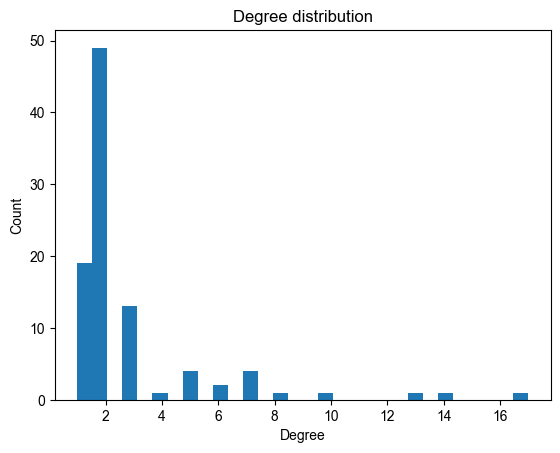

In [136]:
degrees = [d for _, d in G.degree()]
plt.figure()
plt.hist(degrees, bins=30)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution")
plt.show()


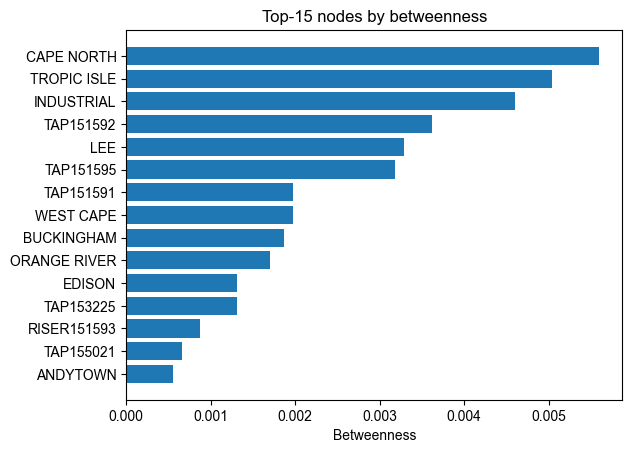

In [137]:
import matplotlib.pyplot as plt

top = nodes_df.sort_values("betweenness", ascending=False).head(15)
plt.figure()
plt.barh(top["node"].astype(str), top["betweenness"])
plt.xlabel("Betweenness")
plt.title("Top-15 nodes by betweenness")
plt.gca().invert_yaxis()
plt.show()


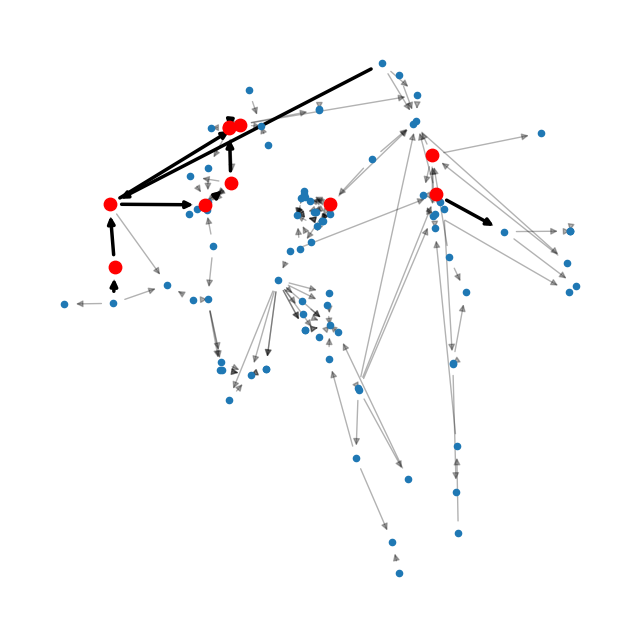

In [138]:
pos = pos  # your dict: node -> (x, y)

top_nodes = set(nodes_df.sort_values("betweenness", ascending=False).head(10)["node"])
top_edges = set(tuple(x) for x in edges_df.sort_values("edge_betweenness", ascending=False).head(10)[["u","v"]].to_numpy())

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_nodes(G, pos, nodelist=list(top_nodes), node_size=80, node_color="red")
nx.draw_networkx_edges(G, pos, edgelist=list(top_edges), width=2.5)
# plt.title("Network with top critical nodes/edges highlighted (based on betweenness)")
plt.axis("off")
plt.show()


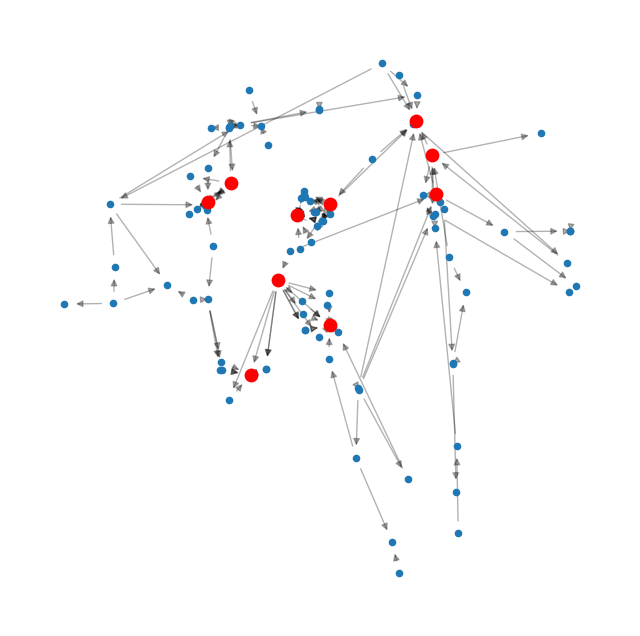

In [139]:
pos = pos  # your dict: node -> (x, y)

top_nodes = set(nodes_df.sort_values("degree", ascending=False).head(10)["node"])
# top_edges = set(tuple(x) for x in edges_df.sort_values("edge_betweenness", ascending=False).head(10)[["u","v"]].to_numpy())

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_nodes(G, pos, nodelist=list(top_nodes), node_size=80, node_color="red")
# nx.draw_networkx_edges(G, pos, edgelist=list(top_edges), width=2.5)
# plt.title("Network with top critical nodes/edges highlighted (based on betweenness)")
plt.axis("off")
plt.show()


In [140]:
top_nodes

{'BUCKINGHAM',
 'EDISON',
 'FORT MYERS SWITCHYARD',
 'Hosp_0',
 'Hosp_1',
 'Hosp_3',
 'Hosp_4',
 'ORANGE RIVER',
 'TAP151595',
 'TROPIC ISLE'}

## Subgraph

In [141]:
def subgraph_by_etype(G, keep_prefix):
    edges = [(u,v) for u,v,d in G.edges(data=True) if str(d.get("edge_type","")).startswith(keep_prefix)]
    return G.edge_subgraph(edges).copy()

G_power = subgraph_by_etype(G, "power_transmission")
G_power_hosp  = subgraph_by_etype(G, "power_hospital")
G_comm  = subgraph_by_etype(G, "comm_hospital")
G_power_comm  = subgraph_by_etype(G, "substation_comm")

layer_summary = pd.DataFrame([
    summarize_graph(G_power, "power_transmission"),
    summarize_graph(G_power_hosp, "power_hospital"),
    summarize_graph(G_comm,  "comm_hospital"),
    summarize_graph(G_power_comm,  "substation_comm")
])

layer_summary

,name,is_directed,N_nodes,M_edges,density,n_weak_components,gcc_frac_weak,avg_degree_total,max_degree_total,avg_path_len_GCC_und,diameter_GCC_und,global_efficiency_und,avg_clustering_und,avg_in_degree,max_in_degree,avg_out_degree,max_out_degree,lscc_frac,avg_path_len_LSCC_dir,diameter_LSCC_dir,avg_clustering_dir
0,power_transmission,True,57,67,0.020990,1,1.000000,2.350877,8,4.807644,10,0.268615,0.064453,1.175439,8,1.175439,5,0.017544,NaN,NaN,0.032226
1,power_hospital,True,7,4,0.095238,3,0.428571,1.142857,2,1.333333,2,0.214286,0.000000,0.571429,1,0.571429,2,0.142857,NaN,NaN,0.000000
2,comm_hospital,True,38,34,0.024182,4,0.368421,1.789474,13,1.857143,2,0.150782,0.000000,0.894737,13,0.894737,1,0.026316,NaN,NaN,0.000000
3,substation_comm,True,41,34,0.020732,7,0.341463,1.658537,13,1.857143,2,0.122561,0.000000,0.829268,1,0.829268,13,0.024390,NaN,NaN,0.000000


In [142]:
# layer_summary.to_csv(r"../output/topo_layer.csv", index=False)

## Hospital-focused (TBC)

# hospitals found: 4

=== Hospital Baseline Connectivity Summary ===

Power provider redundancy (counts):
power_redundancy
1 (single)    4

Comm provider redundancy (counts):
comm_redundancy
2+ (redundant)    4

GCC membership (fraction of hospitals):
in_GCC_integrated: 1.000
in_GCC_power: 1.000
in_GCC_comm: 0.500

Provider count stats:
       n_power_providers  n_comm_providers
count                4.0             4.000
mean                 1.0             8.500
std                  0.0             3.317
min                  1.0             6.000
25%                  1.0             6.000
50%                  1.0             7.500
75%                  1.0            10.000
max                  1.0            13.000

Hospitals with NO power providers:
Empty DataFrame
Columns: [hospital, deg_integrated, deg_power_edges]
Index: []

Hospitals with NO comm providers:
Empty DataFrame
Columns: [hospital, deg_integrated, deg_comm_edges]
Index: []

Saved: hospital_baseline_metrics.csv


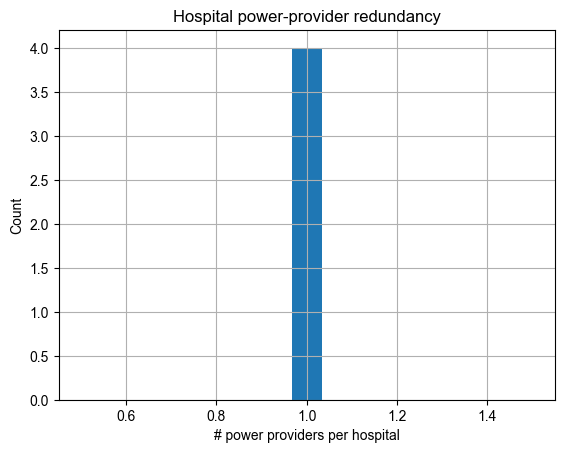

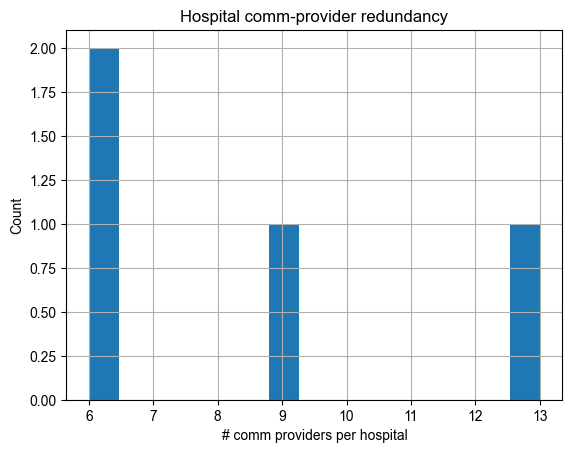

In [143]:
import networkx as nx
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# ----------------------------
# User-configurable keys/labels
# ----------------------------
NODE_TYPE_KEY = "type"          # e.g., "type" or "ntype"
HOSPITAL_LABELS = {"hospitals"} # change to {"hospital"} if needed
EDGE_TYPE_KEY = "edge_type"     # e.g., "edge_type" or "etype"

# Define what counts as "power provider" vs "comm provider" by NODE type.
# Adjust these to match your node taxonomy.
POWER_PROVIDER_NODETYPES = {"substations", "plants", "substation", "plant"}
COMM_PROVIDER_NODETYPES  = {"comm_towers", "tower", "comm_tower", "commtower"}

# Define what counts as power vs comm by EDGE type string matching.
# Adjust to your encoding (e.g. "138 kV", "230 kV", etc.)
def is_power_edge(ed):
    return "kV" in str(ed.get(EDGE_TYPE_KEY, "")) or "power" in str(ed.get(EDGE_TYPE_KEY, "")).lower()

def is_comm_edge(ed):
    s = str(ed.get(EDGE_TYPE_KEY, "")).lower()
    return "comm" in s

# ----------------------------
# Helpers
# ----------------------------
def get_hospitals(G):
    return [n for n, d in G.nodes(data=True) if d.get(NODE_TYPE_KEY) in HOSPITAL_LABELS]

def gcc_nodes(G):
    """Return node set of GCC (weakly connected if directed)."""
    if G.number_of_nodes() == 0:
        return set()
    if G.is_directed():
        comps = list(nx.weakly_connected_components(G))
    else:
        comps = list(nx.connected_components(G))
    return max(comps, key=len) if comps else set()

def subgraph_by_edge_filter(G, edge_keep_fn):
    edges = [(u, v) for u, v, d in G.edges(data=True) if edge_keep_fn(d)]
    return G.edge_subgraph(edges).copy()

# Build layer-ish subgraphs from the same node set (edges filtered)
G_power = subgraph_by_edge_filter(G, is_power_edge)
G_comm  = subgraph_by_edge_filter(G, is_comm_edge)

# GCC sets for membership flags
gcc_integrated = set(gcc_nodes(G.to_undirected()))
gcc_power      = set(gcc_nodes(G_power.to_undirected()))
gcc_comm       = set(gcc_nodes(G_comm.to_undirected()))

hospitals = get_hospitals(G)
print(f"# hospitals found: {len(hospitals)}")

# ----------------------------
# Compute baseline hospital metrics
# ----------------------------
rows = []
for h in hospitals:
    # Integrated neighbors
    neigh = set(G.neighbors(h)) if not G.is_directed() else set(G.to_undirected().neighbors(h))

    # Provider neighbors by NODE type
    power_providers_by_node = {j for j in neigh if G.nodes[j].get(NODE_TYPE_KEY) in POWER_PROVIDER_NODETYPES}
    comm_providers_by_node  = {j for j in neigh if G.nodes[j].get(NODE_TYPE_KEY) in COMM_PROVIDER_NODETYPES}

    # Provider neighbors by EDGE type (more robust when node typing is imperfect)
    power_providers_by_edge = set()
    comm_providers_by_edge  = set()

    for j in neigh:
        # Look for ANY edge between h and j that matches power/comm definition
        # Works for simple Graph/DiGraph. If MultiGraph, see note below.
        ed = G.get_edge_data(h, j, default={}) or G.get_edge_data(j, h, default={}) or {}
        # In a MultiGraph, ed is a dict-of-dicts; handle that case:
        if G.is_multigraph():
            for _, attr in ed.items():
                if is_power_edge(attr):
                    power_providers_by_edge.add(j)
                if is_comm_edge(attr):
                    comm_providers_by_edge.add(j)
        else:
            if is_power_edge(ed):
                power_providers_by_edge.add(j)
            if is_comm_edge(ed):
                comm_providers_by_edge.add(j)

    # Degrees
    deg_integrated = G.degree(h)
    deg_power = G_power.degree(h) if h in G_power else 0
    deg_comm  = G_comm.degree(h) if h in G_comm else 0

    # Provider counts (take union of node-type and edge-type approaches)
    power_providers = power_providers_by_node.union(power_providers_by_edge)
    comm_providers  = comm_providers_by_node.union(comm_providers_by_edge)

    rows.append({
        "hospital": h,
        "deg_integrated": deg_integrated,
        "deg_power_edges": deg_power,
        "deg_comm_edges": deg_comm,
        "n_power_providers": len(power_providers),
        "n_comm_providers": len(comm_providers),
        "in_GCC_integrated": h in gcc_integrated,
        "in_GCC_power": h in gcc_power,
        "in_GCC_comm": h in gcc_comm,
    })

df_hosp = pd.DataFrame(rows)

# Redundancy classes
def redundancy_class(x):
    if x == 0:
        return "0 (none)"
    if x == 1:
        return "1 (single)"
    return "2+ (redundant)"

df_hosp["power_redundancy"] = df_hosp["n_power_providers"].apply(redundancy_class)
df_hosp["comm_redundancy"]  = df_hosp["n_comm_providers"].apply(redundancy_class)

# ----------------------------
# Print concise baseline summary
# ----------------------------
print("\n=== Hospital Baseline Connectivity Summary ===")

print("\nPower provider redundancy (counts):")
print(df_hosp["power_redundancy"].value_counts().to_string())

print("\nComm provider redundancy (counts):")
print(df_hosp["comm_redundancy"].value_counts().to_string())

print("\nGCC membership (fraction of hospitals):")
for col in ["in_GCC_integrated", "in_GCC_power", "in_GCC_comm"]:
    frac = df_hosp[col].mean() if len(df_hosp) else float("nan")
    print(f"{col}: {frac:.3f}")

print("\nProvider count stats:")
print(df_hosp[["n_power_providers","n_comm_providers"]].describe().round(3).to_string())

# Optional: list most vulnerable hospitals (no providers)
print("\nHospitals with NO power providers:")
print(df_hosp.loc[df_hosp["n_power_providers"] == 0, ["hospital","deg_integrated","deg_power_edges"]].to_string(index=False))

print("\nHospitals with NO comm providers:")
print(df_hosp.loc[df_hosp["n_comm_providers"] == 0, ["hospital","deg_integrated","deg_comm_edges"]].to_string(index=False))

# ----------------------------
# Save hospital-level table
# ----------------------------
df_hosp.to_csv("hospital_baseline_metrics.csv", index=False)
print("\nSaved: hospital_baseline_metrics.csv")

# ----------------------------
# Optional plots (simple, publication-friendly)
# ----------------------------
plt.figure()
df_hosp["n_power_providers"].hist(bins=15)
plt.xlabel("# power providers per hospital")
plt.ylabel("Count")
plt.title("Hospital power-provider redundancy")
plt.show()

plt.figure()
df_hosp["n_comm_providers"].hist(bins=15)
plt.xlabel("# comm providers per hospital")
plt.ylabel("Count")
plt.title("Hospital comm-provider redundancy")
plt.show()


### Immediate parent nodes (direct predecessors)

In [144]:
hospitals = [n for n, d in G.nodes(data=True) if d.get("type") == "hospitals"]
hospitals

['Hosp_0', 'Hosp_1', 'Hosp_3', 'Hosp_4']

In [145]:
for h in hospitals:
    parents = list(G.predecessors(h))
    print(f"\nHospital {h}")
    print("  Direct parents:", parents)


Hospital Hosp_0
  Direct parents: ['EDISON', 'Comm_40', 'Comm_46', 'Comm_87', 'Comm_91', 'Comm_135', 'Comm_181']

Hospital Hosp_1
  Direct parents: ['EDISON', 'Comm_17', 'Comm_72', 'Comm_93', 'Comm_94', 'Comm_118', 'Comm_144', 'Comm_146', 'Comm_163', 'Comm_204']

Hospital Hosp_3
  Direct parents: ['TAP151595', 'Comm_24', 'Comm_32', 'Comm_48', 'Comm_52', 'Comm_66', 'Comm_83', 'Comm_122', 'Comm_124', 'Comm_128', 'Comm_139', 'Comm_150', 'Comm_159', 'Comm_174']

Hospital Hosp_4
  Direct parents: ['TROPIC ISLE', 'Comm_55', 'Comm_100', 'Comm_117', 'Comm_129', 'Comm_180', 'Comm_185']


#### All upstream parent nodes (any distance)

In [146]:
for h in hospitals:
    upstream = nx.ancestors(G, h)
    print(f"\nHospital {h}")
    print(f"  Upstream nodes ({len(upstream)}):")
    print(sorted(upstream))


Hospital Hosp_0
  Upstream nodes (11):
['COLONIAL', 'Comm_135', 'Comm_181', 'Comm_40', 'Comm_46', 'Comm_87', 'Comm_91', 'EDISON', 'EVEREST', 'RISER151593', 'SOUTH CAPE']

Hospital Hosp_1
  Upstream nodes (14):
['ALICO', 'COLONIAL', 'Comm_118', 'Comm_144', 'Comm_146', 'Comm_163', 'Comm_17', 'Comm_204', 'Comm_72', 'Comm_93', 'Comm_94', 'EDISON', 'ESTERO', 'TERRY']

Hospital Hosp_3
  Upstream nodes (16):
['Comm_122', 'Comm_124', 'Comm_128', 'Comm_139', 'Comm_150', 'Comm_159', 'Comm_174', 'Comm_24', 'Comm_32', 'Comm_48', 'Comm_52', 'Comm_66', 'Comm_83', 'FORT MYERS', 'HANSON', 'TAP151595']

Hospital Hosp_4
  Upstream nodes (17):
['AQUALINDA', 'CAPE NORTH', 'CHARLOTTE', 'CORBETT', 'Comm_100', 'Comm_117', 'Comm_129', 'Comm_180', 'Comm_185', 'Comm_55', 'EVEREST', 'INDUSTRIAL', 'LEE', 'TAP151591', 'TAP151592', 'TROPIC ISLE', 'WEST CAPE']


#### Actual path

In [147]:
# Shortest path from every reachable upstream node
for h in hospitals:
    print(f"\nHospital {h}")
    upstream = nx.ancestors(G, h)

    for src in upstream:
        try:
            path = nx.shortest_path(G, source=src, target=h)
            print("  → ".join(path))
        except nx.NetworkXNoPath:
            pass


Hospital Hosp_0
RISER151593  → Comm_40  → Hosp_0
Comm_91  → Hosp_0
SOUTH CAPE  → RISER151593  → Comm_91  → Hosp_0
EDISON  → Hosp_0
Comm_87  → Hosp_0
Comm_46  → Hosp_0
EVEREST  → RISER151593  → Comm_91  → Hosp_0
Comm_40  → Hosp_0
Comm_181  → Hosp_0
Comm_135  → Hosp_0
COLONIAL  → EDISON  → Hosp_0

Hospital Hosp_1
Comm_94  → Hosp_1
Comm_146  → Hosp_1
Comm_163  → Hosp_1
Comm_118  → Hosp_1
Comm_144  → Hosp_1
EDISON  → Hosp_1
TERRY  → Comm_72  → Hosp_1
ALICO  → TERRY  → Comm_72  → Hosp_1
Comm_93  → Hosp_1
ESTERO  → Comm_94  → Hosp_1
Comm_17  → Hosp_1
COLONIAL  → EDISON  → Hosp_1
Comm_204  → Hosp_1
Comm_72  → Hosp_1

Hospital Hosp_3
Comm_24  → Hosp_3
Comm_48  → Hosp_3
Comm_122  → Hosp_3
Comm_159  → Hosp_3
Comm_32  → Hosp_3
TAP151595  → Hosp_3
Comm_128  → Hosp_3
Comm_66  → Hosp_3
Comm_52  → Hosp_3
Comm_150  → Hosp_3
Comm_139  → Hosp_3
HANSON  → TAP151595  → Hosp_3
Comm_83  → Hosp_3
FORT MYERS  → TAP151595  → Hosp_3
Comm_124  → Hosp_3
Comm_174  → Hosp_3

Hospital Hosp_4
CAPE NORTH  → INDUSTRIA

In [148]:
# Shortest path from roots only
roots = [n for n in G.nodes() if G.in_degree(n) == 0]

for h in hospitals:
    print(f"\nHospital {h}")
    for r in roots:
        if nx.has_path(G, r, h):
            path = nx.shortest_path(G, r, h)
            print("  ROOT PATH:", " → ".join(path))



Hospital Hosp_0
  ROOT PATH: EVEREST → RISER151593 → Comm_91 → Hosp_0
  ROOT PATH: SOUTH CAPE → RISER151593 → Comm_91 → Hosp_0
  ROOT PATH: COLONIAL → EDISON → Hosp_0

Hospital Hosp_1
  ROOT PATH: ALICO → TERRY → Comm_72 → Hosp_1
  ROOT PATH: COLONIAL → EDISON → Hosp_1

Hospital Hosp_3
  ROOT PATH: FORT MYERS → TAP151595 → Hosp_3
  ROOT PATH: HANSON → TAP151595 → Hosp_3

Hospital Hosp_4
  ROOT PATH: CHARLOTTE → CAPE NORTH → INDUSTRIAL → TROPIC ISLE → Hosp_4
  ROOT PATH: CORBETT → TAP151591 → TAP151592 → Comm_129 → Hosp_4
  ROOT PATH: EVEREST → INDUSTRIAL → TROPIC ISLE → Hosp_4
  ROOT PATH: AQUALINDA → WEST CAPE → CAPE NORTH → INDUSTRIAL → TROPIC ISLE → Hosp_4


#### Visualization

In [149]:
import networkx as nx

def get_upstream_subgraph(G, hospital, depth=3):
    """
    Returns a directed subgraph containing the hospital and all predecessor
    nodes within 'depth' hops, plus all edges among them.
    """
    if hospital not in G:
        return None

    visited = {hospital}
    frontier = {hospital}

    for _ in range(depth):
        new_frontier = set()
        for x in frontier:
            new_frontier.update(G.predecessors(x))  # parents of x
        new_frontier -= visited
        visited |= new_frontier
        frontier = new_frontier
        if not frontier:
            break

    # Induced subgraph on visited nodes (keeps all edges among them)
    return G.subgraph(visited).copy()


In [150]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import networkx as nx

# Set fixed colors for each node type (edit as you like)
TYPE_COLORS = {
    "hospitals": "blue",
    "communication": "orange",
    "substations": "red",
    "plants": "darkred",
    "unknown": "lightgray",
}

def plot_hospital_subgraph(
    G,
    hospital,
    depth=3,
    layout="spring",      # "spring" or "kamada_kawai"
    figsize=(9, 7),
    label_types=("hospital", "substation"),
    savepath=None
):
    Gsub = get_upstream_subgraph(G, hospital, depth=depth)
    if Gsub is None or Gsub.number_of_nodes() <= 1:
        print(f"[{hospital}] No parent nodes found within depth={depth} (or hospital missing).")
        return

    # ----- layout -----
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(Gsub)
    else:
        pos = nx.spring_layout(Gsub, seed=42)

    # ----- node colors by explicit type mapping -----
    node_types = [G.nodes[n].get("type", "unknown") for n in Gsub.nodes()]
    node_colors = [TYPE_COLORS.get(t, TYPE_COLORS["unknown"]) for t in node_types]
    node_sizes = [900 if n == hospital else 380 for n in Gsub.nodes()]

    plt.figure(figsize=figsize)

    nx.draw_networkx_nodes(
        Gsub, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors="black",
        linewidths=0.8
    )

    # ----- edges by edge_type -----
    edges_by_type = {}
    if isinstance(Gsub, (nx.MultiDiGraph, nx.MultiGraph)):
        for u, v, k, data in Gsub.edges(keys=True, data=True):
            et = data.get("edge_type", "unknown")
            edges_by_type.setdefault(et, []).append((u, v, k))
    else:
        for u, v, data in Gsub.edges(data=True):
            et = data.get("edge_type", "unknown")
            edges_by_type.setdefault(et, []).append((u, v))

    edge_styles = ["solid", "dashed", "dotted", "dashdot"]
    for i, (et, elist) in enumerate(sorted(edges_by_type.items(), key=lambda x: x[0])):
        style = edge_styles[i % len(edge_styles)]
        if isinstance(Gsub, (nx.MultiDiGraph, nx.MultiGraph)):
            uv = [(u, v) for (u, v, k) in elist]
        else:
            uv = elist

        nx.draw_networkx_edges(
            Gsub, pos,
            edgelist=uv,
            arrows=True, arrowstyle="-|>", arrowsize=14,
            width=1.2, alpha=0.85,
            style=style
        )

    # ----- labels (only selected node types to reduce clutter) -----
    labels = {}
    for n in Gsub.nodes():
        if n == hospital:
            labels[n] = str(n)
        elif G.nodes[n].get("type") in set(label_types):
            labels[n] = str(n)

    nx.draw_networkx_labels(Gsub, pos, labels=labels, font_size=9)

    # ----- legends -----
    # Only include types that appear in this subgraph
    unique_types = sorted(set(node_types))
    node_legend = [
        Patch(facecolor=TYPE_COLORS.get(t, TYPE_COLORS["unknown"]),
              edgecolor="black",
              label=f"type: {t}")
        for t in unique_types
    ]

    edge_legend = [
        Line2D([0], [0],
               linestyle=edge_styles[i % len(edge_styles)],
               linewidth=2,
               label=f"edge_type: {et}")
        for i, et in enumerate(sorted(edges_by_type.keys()))
    ]

    plt.title(
        f"Hospital subgraph: {hospital} | parent depth={depth}\n"
        f"Nodes={Gsub.number_of_nodes()} | Edges={Gsub.number_of_edges()}"
    )
    plt.axis("off")
    plt.legend(handles=(node_legend + edge_legend), loc="lower left", frameon=True, fontsize=9)

    if savepath:
        plt.tight_layout()
        plt.savefig(savepath, dpi=200)
    plt.show()


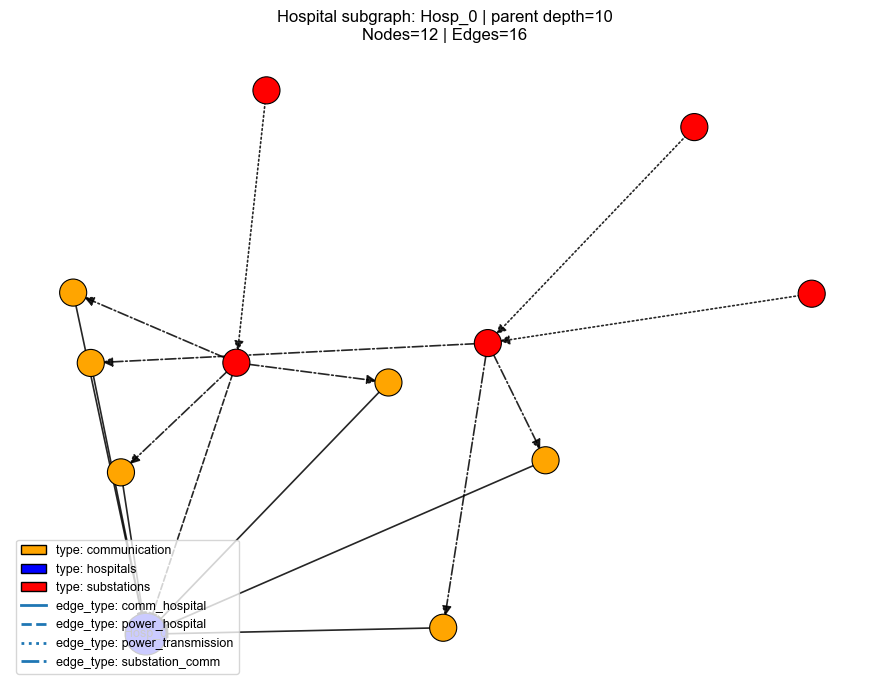

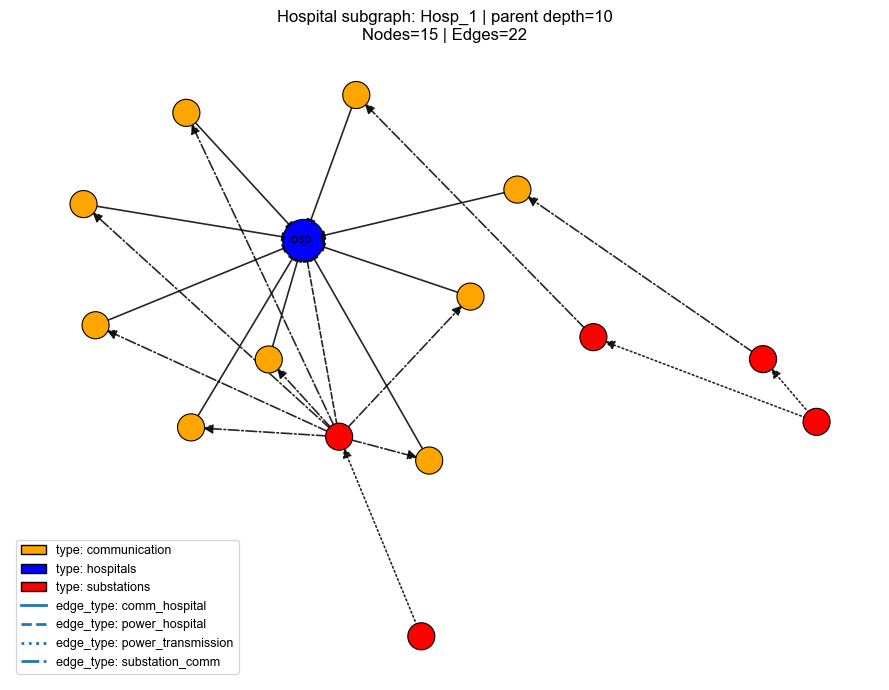

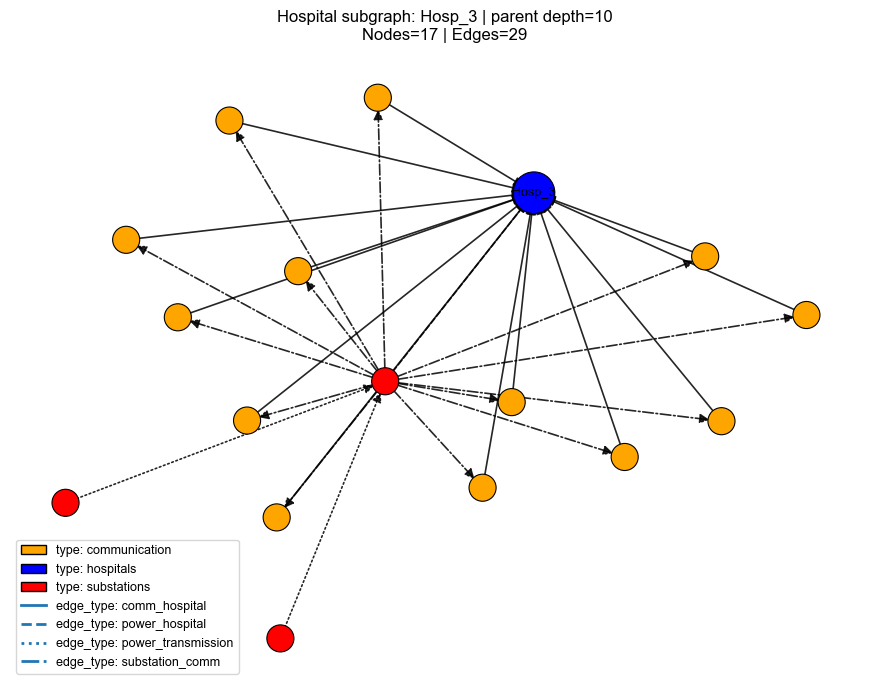

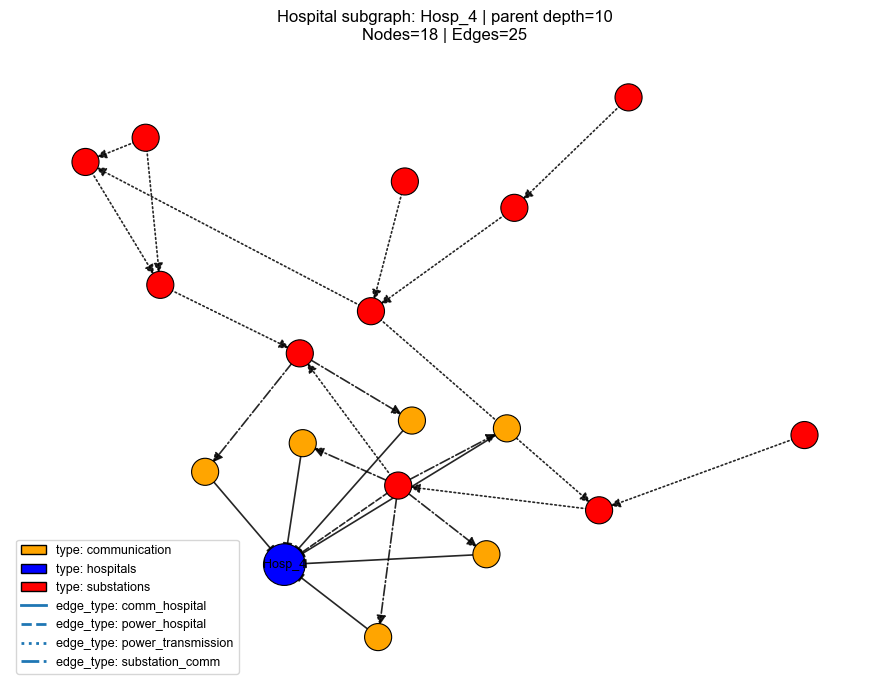

In [151]:
hospitals = [n for n, d in G.nodes(data=True) if d.get("type") == "hospitals"]

for h in hospitals:
    plot_hospital_subgraph(
        G, h,
        depth=10,  # increase if you want a larger parent neighborhood
        layout="spring",
        savepath=f"../output/{h}_subgraph.png"  # optional
    )


# Save the network

In [113]:
import pickle

with open("G.pkl", "wb") as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)

In [114]:
from pathlib import Path
import pickle

local_cache = Path.home()
local_cache.mkdir(exist_ok=True)

with open(local_cache / "G.pkl", "wb") as f:
    pickle.dump(G, f)


In [5]:
import pickle

with open("G.pkl", "rb") as f:
    G = pickle.load(f)


# DBN

- Conditional probability for any node $ i $ at time $ t $ is:
$$
P(X_{i,t} \mid X_{i,t-1},Parents(X_{i,t}),Flood_t)
$$
- based on Markov assumption (The future state depends only on the current state, and the past beyond $X_t$ is irrelevant):
$$
P(X_{t+1} \mid X_t, X_{t-1}, \ldots) = P(X_{t+1} \mid X_t)
$$

## Toy example

In [116]:
G = nx.DiGraph()
G.add_edges_from([
    ("P", "S"),
    ("S", "C"),
    ("S", "H"),
    ("C", "H"),
])


### fragility curve

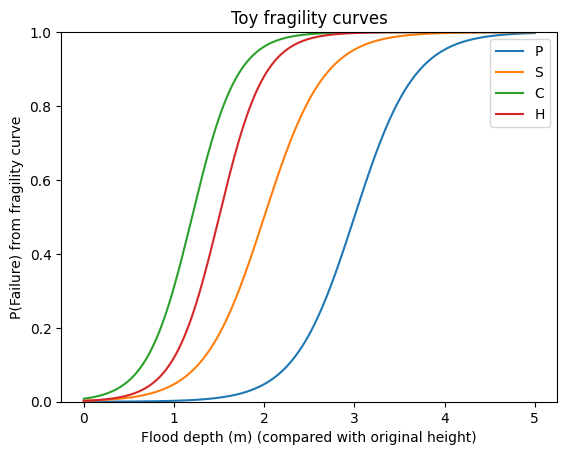

In [117]:
# fragility curve (surface)
import math
import random

def logistic_fragility(depth_m, alpha, beta):
    z = alpha * (depth_m - beta)
    return 1.0 / (1.0 + np.exp(-z))

FRAG = {
    "P": {"alpha": 3.0, "beta": 3.0},
    "S": {"alpha": 3.0, "beta": 2.0},
    "C": {"alpha": 4.0, "beta": 1.2},
    "H": {"alpha": 4.0, "beta": 1.5},
}

def base_fail_prob(node, depth_m):
    prm = FRAG[node]
    return logistic_fragility(depth_m, prm["alpha"], prm["beta"])

depths = np.linspace(0, 5.0, 301)

plt.figure()
for name, prm in FRAG.items():
    plt.plot(depths, logistic_fragility(depths, prm["alpha"], prm["beta"]), label=name)
plt.xlabel("Flood depth (m) (compared with original height)")
plt.ylabel("P(Failure) from fragility curve")
plt.title("Toy fragility curves")
plt.ylim(0, 1)
plt.legend()
plt.show()


### dependency

In [118]:
# dependency paramters
# Extra failure risk induced by parent outages (per time step)
q_PS = 0.99   # if plant down -> substation functionally down (single supply)
q_SC = 0.60   # if substation down -> comm failure risk (backup power buffers)
rS_H = 0.25   # if substation down -> hospital extra risk (generator imperfect)
rC_H = 0.15   # if comm down -> hospital extra risk (ops degrade)

# Persistence: if failed at t-1, stays failed with high prob
# it is hard to repair quickly in an extreme events
p_stay_failed = 0.99

def combine_fail(p_base, extras):
    """1 - (1-p_base) Π (1-extra)"""
    surv = 1.0 - p_base
    # print(surv)
    for e in extras:
        surv *= (1.0 - e)
        # print(e)
    return 1.0 - surv


In [124]:
combine_fail(0.7, [0.2, 0.3])
# P_f = 1 - (1.0 - 0.7) * (1.0 - 0.2) * (1.0 - 0.3)
# P_f = 1 - P_surv

0.832

In [371]:
# always consider two time slices
def step_transition(prev_state, depths_t):
    """
    prev_state: dict node -> {0,1} at time t-1
    depths_t: dict node -> depth (m) at time t
    returns: new_state dict at time t
    """
    new_state = {}

    # 1) Plant (only flood + persistence)
    pP_base = base_fail_prob("P", depths_t["P"])
    if prev_state["P"] == 0:
        pP_fail = p_stay_failed
    else:
        pP_fail = pP_base
    new_state["P"] = 0 if random.random() < pP_fail else 1 # for example, pP_fail = 0.3, about 30% of the time → random.random () < 0.3, plant fails

    # 2) Substation depends on flood + plant + persistence
    pS_base = base_fail_prob("S", depths_t["S"])
    if prev_state["S"] == 0:
        pS_fail = p_stay_failed
    else:
        extras = [q_PS] if new_state["P"] == 0 else []
        pS_fail = combine_fail(pS_base, extras)
    new_state["S"] = 0 if random.random() < pS_fail else 1

    # 3) Comm depends on flood + substation + persistence
    pC_base = base_fail_prob("C", depths_t["C"])
    if prev_state["C"] == 0:
        pC_fail = p_stay_failed
    else:
        extras = [q_SC] if new_state["S"] == 0 else []
        pC_fail = combine_fail(pC_base, extras)
    new_state["C"] = 0 if random.random() < pC_fail else 1

    # 4) Hospital depends on flood + substation + comm + persistence
    pH_base = base_fail_prob("H", depths_t["H"])
    if prev_state["H"] == 0:
        pH_fail = p_stay_failed
    else:
        extras = []
        if new_state["S"] == 0:
            extras.append(rS_H)
        if new_state["C"] == 0:
            extras.append(rC_H)
        pH_fail = combine_fail(pH_base, extras)
    new_state["H"] = 0 if random.random() < pH_fail else 1

    return new_state


### constant inundation depth

In [372]:
def simulate(T=24, depth_series=None, seed=0):
    """
    depth_series: list of dicts, length T, each dict node->depth_m at time t
                 If None, uses constant depth 1.0m everywhere.
    """
    random.seed(seed)
    
    if depth_series is None:
        depth_series = [{"P": 0.8, "S": 0.7, "C": 0.3, "H": 0.5} for _ in range(T)]

    # initial: all functional
    state = {"P": 1, "S": 1, "C": 1, "H": 1}

    history = [state.copy()]
    for t in range(T):
        state = step_transition(state, depth_series[t])
        history.append(state.copy())
    return history

hist = simulate(T=12, seed=42)
hist

[{'P': 1, 'S': 1, 'C': 1, 'H': 1},
 {'P': 1, 'S': 1, 'C': 1, 'H': 1},
 {'P': 1, 'S': 1, 'C': 1, 'H': 1},
 {'P': 1, 'S': 1, 'C': 1, 'H': 1},
 {'P': 1, 'S': 1, 'C': 1, 'H': 1},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0},
 {'P': 1, 'S': 1, 'C': 1, 'H': 0}]

### time-evolving inundation depth

In [373]:
def simulate(T=24, depth_series=None, seed=0):
    random.seed(seed)
    if depth_series is None:
        depth_series = [{"P": 1.0, "S": 1.0, "C": 1.0, "H": 1.0} for _ in range(T)]
    state = {"P": 1, "S": 1, "C": 1, "H": 1}
    history = [state.copy()]
    for t in range(T):
        state = step_transition(state, depth_series[t])
        history.append(state.copy())
    return history

def monte_carlo(n_runs=10000, T=24, depth_series=None):
    counts_fail = {node: np.zeros(T+1, dtype=int) for node in ["P", "S", "C", "H"]}
    for r in range(n_runs):
        hist = simulate(T=T, depth_series=depth_series, seed=r)
        for t, st in enumerate(hist):
            for node in counts_fail:
                if st[node] == 0:
                    counts_fail[node][t] += 1
    probs_fail = {node: counts_fail[node] / n_runs for node in counts_fail}
    return probs_fail


# =========================
# 3) Example flood depth time series + plots
# =========================
T = 24
t = np.arange(T)

# toy storm tide pulse (same depth at all assets for demo)
pulse = 0.2 + 0.8 * np.exp(-0.5 * ((t - 10) / 3.0) ** 2)  # meters

depth_series = [
    {"P": float(pulse[i]), "S": float(pulse[i]), "C": float(pulse[i]), "H": float(pulse[i])}
    for i in range(T)
]

probs = monte_carlo(n_runs=3000, T=T, depth_series=depth_series)

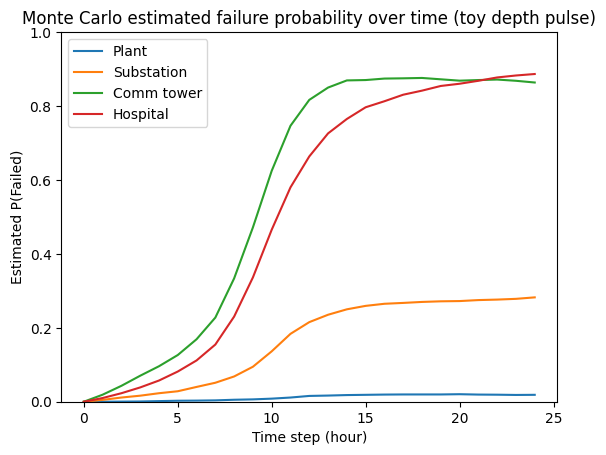

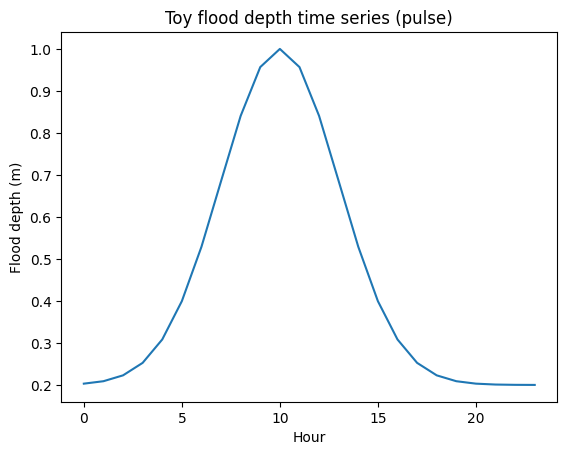

In [374]:
# probability over time
plt.figure()
time_axis = np.arange(T + 1)  # includes initial state at t=0
plt.plot(time_axis, probs["P"], label="Plant")
plt.plot(time_axis, probs["S"], label="Substation")
plt.plot(time_axis, probs["C"], label="Comm tower")
plt.plot(time_axis, probs["H"], label="Hospital")
plt.xlabel("Time step (hour)")
plt.ylabel("Estimated P(Failed)")
plt.title("Monte Carlo estimated failure probability over time (toy depth pulse)")
plt.ylim(0, 1)
plt.legend()
plt.show()

# depth pulse used
plt.figure()
plt.plot(t, pulse)
plt.xlabel("Hour")
plt.ylabel("Flood depth (m)")
plt.title("Toy flood depth time series (pulse)")
plt.show()

### repair time (T>=24)

### long-term memory
- inundation time increases -> failure prob based on fragility curve increases

## Hazard event simulation

### NOAA storm surge risk maps

In [181]:
import os, re
import numpy as np
import rasterio
from pyproj import Transformer, CRS

noaa_dir = r"C:\Users\hai\OneDrive - Georgia Institute of Technology\Data\NOAA\US_SLOSH_MOM_Inundation_v4\US_SLOSH_MOM_Inundation_20250923"

# Your graph node CRS
NODE_CRS = "EPSG:3087"

def is_nan(x):
    return x is None or (isinstance(x, float) and np.isnan(x))

def attach_noaa_slosh_categories(G, pos_key="pos", prefix="NOAA_MOM_Cat", scale=1.0):
    """
    Writes node attributes like NOAA_MOM_Cat1 ... NOAA_MOM_Cat5 (in meters).
    scale=1.0 assumes the raster is already meters. If it is cm, use scale=1/100.
    """
    tif_files = [f for f in os.listdir(noaa_dir) if f.lower().endswith(".tif")]

    # match filenames like us_Category4_MOM_Inundation_HIGH.tif
    pat = re.compile(r"Category(\d)", re.IGNORECASE)

    for fn in tif_files:
        m = pat.search(fn)
        if not m:
            continue

        cat = int(m.group(1))
        attr = f"{prefix}{cat}"   # e.g., NOAA_MOM_Cat4
        path = os.path.join(noaa_dir, fn)

        with rasterio.open(path) as src:
            nodata = src.nodata
            raster_crs = src.crs

            if raster_crs is None:
                raise ValueError(f"Raster CRS missing for {fn}. Check the file metadata.")

            # Transform from node CRS -> raster CRS
            to_raster = Transformer.from_crs(NODE_CRS, raster_crs, always_xy=True)

            for n, data in G.nodes(data=True):
                if pos_key not in data:
                    continue

                x, y = data[pos_key]
                rx, ry = to_raster.transform(x, y)

                val = next(src.sample([(rx, ry)]))[0]

                # nodata check BEFORE scaling
                if nodata is not None and val == nodata:
                    data[attr] = np.nan
                    continue

                depth = float(val) * scale
                depth_m = float(val) * 0.3048
                data[attr] = depth_m if not np.isnan(depth_m) else np.nan


        print(f"Attached {attr} from {fn}")

# Run it
attach_noaa_slosh_categories(G)

Attached NOAA_MOM_Cat1 from us_Category1_MOM_Inundation_HIGH.tif
Attached NOAA_MOM_Cat2 from us_Category2_MOM_Inundation_HIGH.tif
Attached NOAA_MOM_Cat3 from us_Category3_MOM_Inundation_HIGH.tif
Attached NOAA_MOM_Cat4 from us_Category4_MOM_Inundation_HIGH.tif
Attached NOAA_MOM_Cat5 from us_Category5_MOM_Inundation_HIGH.tif


In [182]:
# check a node
n0 = next(iter(G.nodes()))
{k: G.nodes[n0].get(k) for k in ["NOAA_MOM_Cat1","NOAA_MOM_Cat2","NOAA_MOM_Cat3","NOAA_MOM_Cat4","NOAA_MOM_Cat5"]}

{'NOAA_MOM_Cat1': nan,
 'NOAA_MOM_Cat2': nan,
 'NOAA_MOM_Cat3': nan,
 'NOAA_MOM_Cat4': nan,
 'NOAA_MOM_Cat5': nan}

### Fathom flood events (return periods) / fluvial/pluvial

In [183]:
G.nodes

NodeView(('ANDYTOWN', 'ORANGE RIVER', 'HERCULES', 'FORT MYERS SWITCHYARD', 'LEE', 'CALUSA', 'TAP141798', 'ORANGETREE', 'TAP141796', 'LIVINGSTON', 'GATEWAY', 'JETPORT', 'CHARLOTTE', 'FORT MYERS', 'DEADEND167096', 'TAP167094', 'TAP152014', 'CAPE NORTH', 'ALICO', 'TERRY', 'BUCKINGHAM', 'COLLIER', 'CORKSCREW', 'SAN CARLOS', 'ALVA', 'TAP141795', 'CORBETT', 'EVEREST', 'INDUSTRIAL', 'SOUTH CAPE', 'CAPE CORAL', 'TAP151595', 'NORTH TRAIL', 'TAP151594', 'AQUALINDA', 'WEST CAPE', 'TROPIC ISLE', 'TAP151592', 'ESTERO', 'PINE ISLAND', 'TAP151591', 'LCEC NO. 5', 'TAP155021', 'LEE COUNTY SOLID WASTE ENERGY', 'PINEY ROAD', 'RISER151593', 'HANSON', 'IMPERIAL', 'BONITA SPRINGS', 'COLONIAL', 'TAP153225', 'DEADEND167093', 'EDISON', 'TAP151589', 'TAP154083', 'SLATER', 'DEADEND167101', 'Fort Myers', 'Lee County Solid Waste Energy', 'Hosp_0', 'Hosp_1', 'Hosp_3', 'Hosp_4', 'Comm_17', 'Comm_24', 'Comm_32', 'Comm_40', 'Comm_46', 'Comm_48', 'Comm_52', 'Comm_55', 'Comm_66', 'Comm_72', 'Comm_83', 'Comm_87', 'Comm_9

In [184]:
to_wgs84 = Transformer.from_crs("EPSG:3087", "EPSG:4326", always_xy=True)

def attach_raster_depth_to_nodes(
    G, raster_path, attr_name,
    transformer=to_wgs84,
    scale=1/100,              # cm -> meters
    only_types=None           # e.g., {"hospitals","substations"} or None for all
):
    with rasterio.open(raster_path) as src:
        nodata = src.nodata

        for n, data in G.nodes(data=True):
            if "pos" not in data:
                continue
            if only_types is not None and data.get("type") not in only_types:
                continue

            x3087, y3087 = data["pos"]
            lon, lat = transformer.transform(x3087, y3087)

            val = next(src.sample([(lon, lat)]))[0]

            # handle nodata before scaling
            if nodata is not None and val == nodata:
                data[attr_name] = np.nan
                continue

            depth_m = float(val) * scale
            data[attr_name] = depth_m if not np.isnan(depth_m) else np.nan

In [185]:
fluvial_dir = r"C:\Users\hai\OneDrive - Georgia Institute of Technology\Data\Fathom\fluvial_defended\fluvial_defended"
pluvial_dir = r"C:\Users\hai\OneDrive - Georgia Institute of Technology\Data\Fathom\pluvial\pluvial"

def parse_return_period(filename):
    # matches "..._1in500.tif" -> 500
    m = re.search(r"1in(\d+)", filename)
    return int(m.group(1)) if m else None

def attach_folder(G, folder, prefix):
    for fn in os.listdir(folder):
        if not fn.lower().endswith(".tif"):
            continue
        rp = parse_return_period(fn)
        if rp is None:
            continue

        attr = f"{prefix}_{rp}"     # e.g., "Fluvial_500"
        path = os.path.join(folder, fn)

        attach_raster_depth_to_nodes(G, path, attr_name=attr)
        print(f"Attached {attr} from {fn}")

attach_folder(G, fluvial_dir, "Fluvial")
attach_folder(G, pluvial_dir, "Pluvial")


Attached Fluvial_100 from fluvial_1in100.tif
Attached Fluvial_1000 from fluvial_1in1000.tif
Attached Fluvial_200 from fluvial_1in200.tif
Attached Fluvial_50 from fluvial_1in50.tif
Attached Fluvial_500 from fluvial_1in500.tif
Attached Pluvial_100 from pluvial_1in100.tif
Attached Pluvial_1000 from pluvial_1in1000.tif
Attached Pluvial_200 from pluvial_1in200.tif
Attached Pluvial_50 from pluvial_1in50.tif
Attached Pluvial_500 from pluvial_1in500.tif


In [186]:
node_data = dict(G.nodes(data=True))
df_nodes = pd.DataFrame.from_dict(node_data, orient='index')
df_nodes = df_nodes.reset_index().rename(columns={'index': 'Node_ID'})
df_nodes

,Node_ID,type,pos,node_voltage_max,node_voltage_min,node_voltage_levels,is_transformer,in_degree,out_degree,total_degree,role,Fluvial_100,Fluvial_1000,Fluvial_200,Fluvial_50,Fluvial_500,Pluvial_100,Pluvial_1000,Pluvial_200,Pluvial_50,Pluvial_500,NOAA_MOM_Cat1,NOAA_MOM_Cat2,NOAA_MOM_Cat3,NOAA_MOM_Cat4,NOAA_MOM_Cat5
0,ANDYTOWN,substations,"(632024.1681999993, 289317.37665)",500.0,500.0,[500.0],False,0.0,1.0,1.0,source,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN
1,ORANGE RIVER,substations,"(621650.9567999989, 298446.2098000003)",500.0,230.0,"[230.0, 500.0]",True,3.0,4.0,7.0,transit,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,NaN,NaN,NaN,0.9144,2.1336
2,HERCULES,substations,"(619151.39855, 305229.30544999987)",230.0,230.0,[230.0],False,0.0,1.0,1.0,source,0.0,0.14,0.0,0.0,0.09,0.0,0.22,0.0,0.0,0.00,NaN,NaN,NaN,1.2192,2.4384
3,FORT MYERS SWITCHYARD,substations,"(620456.2397999987, 301334.6765999999)",230.0,138.0,"[138.0, 230.0]",True,8.0,0.0,8.0,sink,0.0,0.01,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.00,0.3048,1.5240,2.4384,4.5720,5.7912
4,LEE,substations,"(606890.7074999996, 301013.86849999987)",230.0,138.0,"[138.0, 230.0]",True,2.0,4.0,6.0,transit,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,NaN,NaN,NaN,2.1336,3.3528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Comm_174,communication,"(611839.4638999999, 295358.3673999999)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,1.2192,2.4384,3.6576,5.7912,6.4008
93,Comm_180,communication,"(603018.3242999986, 293399.4238999998)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,NaN,NaN,0.9144,3.0480,4.5720
94,Comm_181,communication,"(605414.1319000013, 280227.46920000017)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.9144,2.4384,3.9624,5.4864,6.4008
95,Comm_185,communication,"(603655.3198999986, 293844.2737999996)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.0,0.25,0.0,0.0,0.21,NaN,NaN,1.5240,3.6576,5.1816


In [187]:
return_periods = [50, 100, 200, 500, 1000]

ordered_cols = []

# Fluvial in correct order
ordered_cols += [f"Fluvial_{rp}" for rp in return_periods]

# Pluvial in correct order
ordered_cols += [f"Pluvial_{rp}" for rp in return_periods]

# Hurricane
ordered_cols += [f"NOAA_MOM_Cat{i}" for i in range(1, 6)]

# Keep only columns that actually exist
ordered_cols = [c for c in ordered_cols if c in df_nodes.columns]

df_nodes[ordered_cols].describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
Fluvial_50,97.0,0.0072,0.0355,0.0000,0.0000,0.0000,0.0000,0.2300
Fluvial_100,97.0,0.0133,0.0477,0.0000,0.0000,0.0000,0.0000,0.2700
Fluvial_200,97.0,0.0261,0.1135,0.0000,0.0000,0.0000,0.0000,0.9700
Fluvial_500,97.0,0.0362,0.1369,0.0000,0.0000,0.0000,0.0000,1.1200
Fluvial_1000,97.0,0.0419,0.1494,0.0000,0.0000,0.0000,0.0000,1.1700
Pluvial_50,97.0,0.0485,0.1194,0.0000,0.0000,0.0000,0.0000,0.5800
Pluvial_100,97.0,0.0916,0.1811,0.0000,0.0000,0.0000,0.2000,1.0300
Pluvial_200,97.0,0.1010,0.1898,0.0000,0.0000,0.0000,0.2200,1.0600
Pluvial_500,97.0,0.1284,0.2167,0.0000,0.0000,0.0000,0.2800,1.1400
Pluvial_1000,97.0,0.1690,0.2608,0.0000,0.0000,0.0000,0.3600,1.3600


## HealthPark Medical Center

In [36]:
h = "Hosp_0"
G_hosp = get_upstream_subgraph(G, h, depth=10)

nodes_to_remove = list(G_hosp.nodes())
G_minus_hosp = G.copy()
G_minus_hosp.remove_nodes_from(nodes_to_remove)

In [37]:
print("Original:", G.number_of_nodes(), G.number_of_edges())
print("Hospital subgraph:", G_hosp.number_of_nodes(), G_hosp.number_of_edges())
print("Remaining:", G_minus_hosp.number_of_nodes(), G_minus_hosp.number_of_edges())

Original: 97 141
Hospital subgraph: 12 16
Remaining: 85 114


In [153]:
parents = {n: list(G_hosp.predecessors(n)) for n in G_hosp.nodes()}
parents["Hosp_0"]

['Comm_91', 'EDISON', 'Comm_87', 'Comm_46', 'Comm_40', 'Comm_181', 'Comm_135']

In [154]:
allowed_parent_types = {"substations", "plants", "communication"}

parents_filtered = {}
for n in G_hosp.nodes():
    parents_filtered[n] = [
        p for p in G_hosp.predecessors(n)
        if G.nodes[p].get("type") in allowed_parent_types
    ]


In [152]:
plt.figure(figsize=(20, 20), dpi=600)

# Plants
plant_nodes = [n for n, d in G_hosp.nodes(data=True) if d.get('type') == 'plants']
nx.draw_networkx_nodes(G_hosp, pos, nodelist=plant_nodes, node_size=120, node_color='darkred', label='Plants')
print(plant_nodes)

# Substations
sub_nodes = [n for n, d in G_hosp.nodes(data=True) if d.get('type') == 'substations']
sub_nodes = [n for n in sub_nodes if n in pos]
nx.draw_networkx_nodes(G_hosp, pos, nodelist=sub_nodes, node_size=20, node_color='red', label='Substations')

# Hospitals
hosp_nodes = [n for n, d in G_hosp.nodes(data=True) if d.get('type') == 'hospitals']
nx.draw_networkx_nodes(G_hosp, pos, nodelist=hosp_nodes, node_size=80, node_color='blue', node_shape='P', label='Hospitals')

# Communication powers
comm_nodes = [n for n, d in G_hosp.nodes(data=True) if d.get('type') == 'communication']
nx.draw_networkx_nodes(G_hosp, pos, nodelist=comm_nodes, node_size=15, node_color='orange', label='Comm Towers')

# Edges
for volt in voltages:
    edgelist = [
        (u, v) for u, v, d in G_hosp.edges(data=True) 
        if d.get('VOLTAGE') == volt
    ]
    
    current_width = volt / 100
    if edgelist:
        nx.draw_networkx_edges(
            G_hosp, pos, 
            edgelist=edgelist,
            width=current_width,
            edge_color=[voltage_colors[volt]],
            alpha=0.8,
            label=f"{int(volt)} kV"
        )

comm_edges = [(u, v) for u, v, d in G_hosp.edges(data=True) if d.get('edge_type') == 'comm_hospital']
if comm_edges:
    nx.draw_networkx_edges(G_hosp, pos, edgelist=comm_edges,edge_color='orange', alpha=0.8, width=1.5, label='Comm Link (<3km)')

substation_comm_edges = [(u, v) for u, v, d in G_hosp.edges(data=True) if d.get('edge_type') == 'substation_comm']
if substation_comm_edges:
    nx.draw_networkx_edges(G_hosp, pos, edgelist=substation_comm_edges,edge_color='gray', alpha=0.8, width=1.0, label='Substation Comm Link')

plt.xlim(global_xlim)
plt.ylim(global_ylim)

plt.legend()
plt.title("HealthPark Medical Center Hospital + Power + Communication Network")
plt.axis('off')
plt.show()

[]


### fragility curve/surface (TBC: add wind speed)

- CLiP Lifelines Fragility Database https://fragilitydb.engineering.oregonstate.edu/
- Fragility curves can be derived: (i) empirically from statistical analysis of a large set of observed failures, (ii) experimentally by deliberately failing towers, (iii) analytically using a structural simulation model, (iv) using expert judgment, or (v) through a combination of these methods. 

Reference: TBC

In [155]:
G_hosp.number_of_nodes()

12

In [156]:
G_hosp.number_of_edges()

16

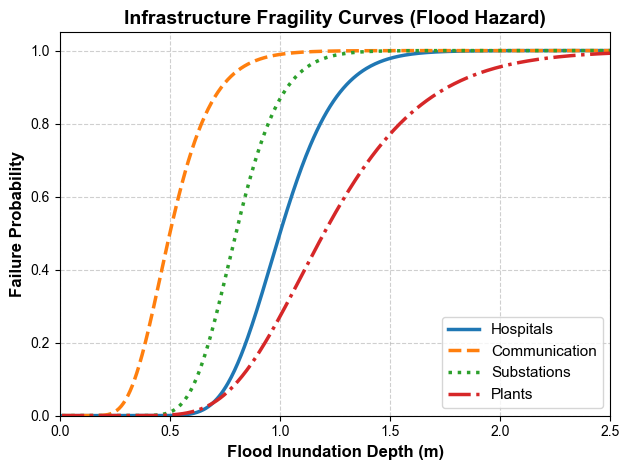

In [157]:
from scipy.stats import norm

def fragility_curve(h, mu, sigma):
    with np.errstate(divide='ignore', invalid='ignore'):
        p_failure = norm.cdf(np.log(h / mu) / sigma)
    p_failure[h <= 0] = 0
    return p_failure

# Flood depth range (m)
h = np.linspace(0.01, 2.5, 500)

nodes_fragility = {
    'Hospitals': (1.0, 0.2, '-'),
    'Communication': (0.5, 0.3, '--'),
    'Substations': (0.8, 0.2, ':'),
    'Plants': (1.2, 0.3, '-.')
}

for label, (mu, sigma, style) in nodes_fragility.items():
    plt.plot(h, fragility_curve(h, mu, sigma), 
             label=label, linewidth=2.5, linestyle=style)

plt.xlabel('Flood Inundation Depth (m)', fontweight='bold', fontsize=12)
plt.ylabel('Failure Probability', fontweight='bold', fontsize=12)
plt.title('Infrastructure Fragility Curves (Flood Hazard)', fontweight='bold', fontsize=14)
plt.xlim(0, 2.5)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig(r'infrastructure_fragility_curves.png', dpi=300)

In [158]:
nodes_fragility = {
    'Hospitals': (1.0, 0.2, '-'),
    'Communication': (0.5, 0.3, '--'),
    'Substations': (0.8, 0.2, ':'),
    'Plants': (1.2, 0.3, '-.')
}

# Map plotting labels → graph node types
LABEL_TO_NODE_TYPE = {
    "Hospitals": "hospital",
    "Communication": "communication",
    "Substations": "substation",
    "Plants": "plant",
}

FRAGILITY_BY_TYPE = {
    LABEL_TO_NODE_TYPE[label]: {
        "mu": mu,
        "sigma": sigma,
        "model": "lognormal"
    }
    for label, (mu, sigma, _) in nodes_fragility.items()
}

FRAGILITY_BY_TYPE


{'hospital': {'mu': 1.0, 'sigma': 0.2, 'model': 'lognormal'},
 'communication': {'mu': 0.5, 'sigma': 0.3, 'model': 'lognormal'},
 'substation': {'mu': 0.8, 'sigma': 0.2, 'model': 'lognormal'},
 'plant': {'mu': 1.2, 'sigma': 0.3, 'model': 'lognormal'}}

In [159]:
for n, d in G_hosp.nodes(data=True):
    ntype = d.get("type", None)
    if ntype in FRAGILITY_BY_TYPE:
        d["fragility"] = FRAGILITY_BY_TYPE[ntype]
    else:
        # safe fallback
        d["fragility"] = {
            "model": "lognormal",
            "mu": 1.0,
            "sigma": 0.3
        }


In [160]:
G_hosp.nodes["Hosp_0"]["fragility"]

{'model': 'lognormal', 'mu': 1.0, 'sigma': 0.3}

### dependency

In [161]:
for n, d in G_hosp.nodes(data=True):
    print(
        f"{n:15s} | "
        f"type={d.get('type')} | "
        f"mu={d.get('fragility', {}).get('mu')} | "
        f"sigma={d.get('fragility', {}).get('sigma')}"
    )


RISER151593     | type=substations | mu=1.0 | sigma=0.3
Comm_91         | type=communication | mu=0.5 | sigma=0.3
Hosp_0          | type=hospitals | mu=1.0 | sigma=0.3
EDISON          | type=substations | mu=1.0 | sigma=0.3
Comm_87         | type=communication | mu=0.5 | sigma=0.3
Comm_46         | type=communication | mu=0.5 | sigma=0.3
EVEREST         | type=substations | mu=1.0 | sigma=0.3
Comm_40         | type=communication | mu=0.5 | sigma=0.3
Comm_181        | type=communication | mu=0.5 | sigma=0.3
COLONIAL        | type=substations | mu=1.0 | sigma=0.3
SOUTH CAPE      | type=substations | mu=1.0 | sigma=0.3
Comm_135        | type=communication | mu=0.5 | sigma=0.3


In [198]:
# Example dependency parameters
EDGE_EXTRA_RISK = {
    ("plant", "substation"): 0.999,        # q_PS
    ("substation", "communication"): 0.60,# q_SC
    ("substation", "hospital"): 0.25,     # rS_H
    ("communication", "hospital"): 0.05,  # rC_H
}

p_stay_failed = 0.999


In [199]:
import numpy as np
import random
from scipy.stats import norm

def combine_fail(p_base, extras):
    """1 - (1-p_base) Π (1-extra)"""
    surv = 1.0 - p_base
    for e in extras:
        surv *= (1.0 - e)
    return 1.0 - surv

def fragility_fail_prob_node(G, node, h):
    """
    Lognormal fragility curve:
    p = Phi( ln(h/mu)/sigma ), with p=0 when h<=0
    Node must have G.nodes[node]["fragility"] = {"mu":..., "sigma":..., "model":"lognormal"}
    """
    frag = G.nodes[node].get("fragility", None)
    if frag is None:
        return 0.0

    mu = frag["mu"]
    sigma = frag["sigma"]

    if h is None or h <= 0:
        return 0.0

    with np.errstate(divide="ignore", invalid="ignore"):
        return float(norm.cdf(np.log(h / mu) / sigma))


In [200]:
import networkx as nx

def step_transition_graph(Gsub, prev_state, depths_t,
                          edge_extra_risk=EDGE_EXTRA_RISK,
                          p_stay_failed=0.99):
    """
    Gsub: directed NetworkX graph (e.g., G_hosp)
    prev_state: dict node -> {0,1} at time t-1 (1=working, 0=failed)
    depths_t: dict node -> hazard intensity at time t (e.g., flood depth)
    returns: new_state dict node -> {0,1} at time t
    """
    new_state = {}

    # Choose update order
    try:
        order = list(nx.topological_sort(Gsub))
    except nx.NetworkXUnfeasible:
        # has cycles; use a stable order (still works, but interpretation is "synchronous-ish")
        order = list(Gsub.nodes())

    for n in order:
        # base failure from fragility
        h = depths_t.get(n, 0.0)
        p_base = fragility_fail_prob_node(Gsub, n, h)

        # persistence
        if prev_state.get(n, 1) == 0:
            p_fail = p_stay_failed
        else:
            extras = []

            # parent influence based on parent/child node types
            for p in Gsub.predecessors(n):
                if new_state.get(p, prev_state.get(p, 1)) == 0:  # parent down at time t
                    ptype = Gsub.nodes[p].get("type", "unknown")
                    ntype = Gsub.nodes[n].get("type", "unknown")
                    extra = edge_extra_risk.get((ptype, ntype), 0.0)
                    if extra > 0:
                        extras.append(extra)

            p_fail = combine_fail(p_base, extras)

        new_state[n] = 0 if random.random() < p_fail else 1

    return new_state


In [201]:
def simulate_failure_probabilities(Gsub, depths_series, n_mc=500, seed=0):
    """
    depths_series: list of dicts, length T
        depths_series[t][node] = hazard at time t (e.g., flood depth)
    Returns:
      p_fail[t][node] = estimated P(node fails at time t)
    """
    random.seed(seed)
    np.random.seed(seed)

    T = len(depths_series)
    nodes = list(Gsub.nodes())

    # store counts of failures
    fail_counts = [{n: 0 for n in nodes} for _ in range(T)]

    for _ in range(n_mc):
        prev_state = {n: 1 for n in nodes}  # start all working

        for t in range(T):
            new_state = step_transition_graph(Gsub, prev_state, depths_series[t])
            for n in nodes:
                if new_state[n] == 0:
                    fail_counts[t][n] += 1
            prev_state = new_state

    # convert to probabilities
    p_fail = [{n: fail_counts[t][n] / n_mc for n in nodes} for t in range(T)]
    return p_fail


### Experiment with different flood return periods

In [202]:
ordered_cols

['Fluvial_50',
 'Fluvial_100',
 'Fluvial_200',
 'Fluvial_500',
 'Fluvial_1000',
 'Pluvial_50',
 'Pluvial_100',
 'Pluvial_200',
 'Pluvial_500',
 'Pluvial_1000',
 'NOAA_MOM_Cat1',
 'NOAA_MOM_Cat2',
 'NOAA_MOM_Cat3',
 'NOAA_MOM_Cat4',
 'NOAA_MOM_Cat5']

In [203]:
node_data = dict(G_hosp.nodes(data=True))
df_hosp_nodes = pd.DataFrame.from_dict(node_data, orient='index')
df_hosp_nodes = df_hosp_nodes.reset_index().rename(columns={'index': 'Node_ID'})
df_hosp_nodes

# Keep only columns that actually exist
ordered_cols = [c for c in ordered_cols if c in df_hosp_nodes.columns]

df_hosp_nodes[ordered_cols].describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
Fluvial_50,12.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Fluvial_100,12.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Fluvial_200,12.0,0.0008,0.0029,0.0000,0.0000,0.0000,0.0000,0.0100
Fluvial_500,12.0,0.0033,0.0115,0.0000,0.0000,0.0000,0.0000,0.0400
Fluvial_1000,12.0,0.0050,0.0173,0.0000,0.0000,0.0000,0.0000,0.0600
Pluvial_50,12.0,0.0433,0.1012,0.0000,0.0000,0.0000,0.0000,0.2600
Pluvial_100,12.0,0.0550,0.1285,0.0000,0.0000,0.0000,0.0000,0.3300
Pluvial_200,12.0,0.0750,0.1406,0.0000,0.0000,0.0000,0.0500,0.3500
Pluvial_500,12.0,0.1050,0.1602,0.0000,0.0000,0.0000,0.2400,0.3800
Pluvial_1000,12.0,0.1308,0.1997,0.0000,0.0000,0.0000,0.2925,0.4700


In [222]:
hosp0_flood_event = df_hosp_nodes[ordered_cols].describe().T.round(4)
hosp0_flood_event.to_csv(r"../output/hosp0_flood_event_describe.csv")

#### Constant depth

In [204]:
T = 24
nodes = list(G_hosp.nodes())

scenario_attr = "NOAA_MOM_Cat4"

base_depth = {n: float(G_hosp.nodes[n].get(scenario_attr, 0.0) or 0.0) for n in nodes}
depths_series = [base_depth.copy() for _ in range(T)]

In [ ]:
p_fail = simulate_failure_probabilities(G_hosp, depths_series, n_mc=1000, seed=42)

final_prob = p_fail[T-1]["Hosp_0"]

0 1.0
1 0.991
2 0.994
3 0.981
4 0.99
5 0.989
6 0.987
7 0.985
8 0.988
9 0.985
10 0.988
11 0.989
12 0.99
13 0.992
14 0.99
15 0.991
16 0.991
17 0.989
18 0.986
19 0.994
20 0.992
21 0.99
22 0.992
23 0.991


In [ ]:
max_prob = max(p_fail[t]["Hosp_0"] for t in range(T))
max_prob

np.float64(0.9897916666666667)

In [ ]:
mean_prob = np.mean([p_fail[t]["Hosp_0"] for t in range(T)])
mean_prob

In [215]:
def summarize_hospital(p_fail, hospital, T):
    series = [p_fail[t].get(hospital, 0) for t in range(T)]
    return {
        "mean": np.mean(series),
        "max": np.max(series),
        "final": series[-1]
    }

In [219]:
events = [
 'Fluvial_50','Fluvial_100','Fluvial_200','Fluvial_500','Fluvial_1000',
 'Pluvial_50','Pluvial_100','Pluvial_200','Pluvial_500','Pluvial_1000',
 'NOAA_MOM_Cat1','NOAA_MOM_Cat2','NOAA_MOM_Cat3','NOAA_MOM_Cat4','NOAA_MOM_Cat5'
]

In [220]:
def build_constant_depth_series(G, scenario_attr, T=24):
    nodes = list(G.nodes())
    
    base = {}
    for n in nodes:
        v = G.nodes[n].get(scenario_attr, 0.0)
        if v is None or (isinstance(v, float) and np.isnan(v)):
            v = 0.0
        base[n] = float(v)

    return [base.copy() for _ in range(T)]

In [ ]:
T = 5
n_mc = 1000
target_node = "Hosp_0"  # change if needed

results = []

for i, ev in enumerate(events):
    
    depths_series = build_constant_depth_series(G_hosp, ev, T=T)
    
    p_fail = simulate_failure_probabilities(
        G_hosp, depths_series, n_mc=n_mc, seed=42+i
    )
    
    series = np.array([p_fail[t].get(target_node, 0.0) for t in range(T)])
    
    results.append({
        "scenario": ev,
        "mean_p_fail": series.mean(),
        "max_p_fail": series.max(),
        "final_p_fail": series[-1]
    })

df_compare_const = pd.DataFrame(results)
df_compare_const.sort_values("scenario")
df_compare_const


,scenario,mean_p_fail,max_p_fail,final_p_fail
0,Fluvial_50,0.0000,0.000,0.000
1,Fluvial_100,0.0000,0.000,0.000
2,Fluvial_200,0.0000,0.000,0.000
3,Fluvial_500,0.0000,0.000,0.000
4,Fluvial_1000,0.0000,0.000,0.000
5,Pluvial_50,0.0000,0.000,0.000
6,Pluvial_100,0.0000,0.000,0.000
7,Pluvial_200,0.0000,0.000,0.000
8,Pluvial_500,0.0000,0.000,0.000
9,Pluvial_1000,0.0000,0.000,0.000


In [224]:
df_compare_const

,scenario,mean_p_fail,max_p_fail,final_p_fail
0,Fluvial_50,0.0000,0.000,0.000
1,Fluvial_100,0.0000,0.000,0.000
2,Fluvial_200,0.0000,0.000,0.000
3,Fluvial_500,0.0000,0.000,0.000
4,Fluvial_1000,0.0000,0.000,0.000
5,Pluvial_50,0.0000,0.000,0.000
6,Pluvial_100,0.0000,0.000,0.000
7,Pluvial_200,0.0000,0.000,0.000
8,Pluvial_500,0.0000,0.000,0.000
9,Pluvial_1000,0.0000,0.000,0.000


In [225]:
T = 24
n_mc = 1000
target_node = "Hosp_0"  # change if needed

results = []

for i, ev in enumerate(events):
    
    depths_series = build_constant_depth_series(G_hosp, ev, T=T)
    
    p_fail = simulate_failure_probabilities(
        G_hosp, depths_series, n_mc=n_mc, seed=42+i
    )
    
    series = np.array([p_fail[t].get(target_node, 0.0) for t in range(T)])
    
    results.append({
        "scenario": ev,
        "mean_p_fail": series.mean(),
        "max_p_fail": series.max(),
        "final_p_fail": series[-1]
    })

df_compare_const24 = pd.DataFrame(results)
df_compare_const24.sort_values("scenario")
df_compare_const24


,scenario,mean_p_fail,max_p_fail,final_p_fail
0,Fluvial_50,0.000000,0.000,0.000
1,Fluvial_100,0.000000,0.000,0.000
2,Fluvial_200,0.000000,0.000,0.000
3,Fluvial_500,0.000000,0.000,0.000
4,Fluvial_1000,0.000000,0.000,0.000
5,Pluvial_50,0.000000,0.000,0.000
6,Pluvial_100,0.000000,0.000,0.000
7,Pluvial_200,0.000000,0.000,0.000
8,Pluvial_500,0.000000,0.000,0.000
9,Pluvial_1000,0.000000,0.000,0.000


In [226]:
df_compare_const24.to_csv(r"../output/p_fail_constant_24steps.csv")

#### Time series

In [229]:
def storm_surge_shape(T=24, rise_hours=6, peak_hours=3):
    """
    Returns a normalized surge shape h(t) in [0,1] with:
    fast rise -> short peak -> slow recession.
    """
    r = min(max(1, rise_hours), T-2)
    p = min(max(1, peak_hours), T-r-1)
    f = T - r - p

    rise = np.linspace(0, 1, r, endpoint=False)
    peak = np.ones(p)
    fall = np.linspace(1, 0, f)

    h = np.concatenate([rise, peak, fall])
    return h

In [230]:
def storm_surge_shape_smooth(T=24, peak_at=10, width=4):
    """
    Smooth unimodal curve (Gaussian-like), normalized to max=1.
    peak_at: time index of peak
    width: controls spread
    """
    t = np.arange(T)
    h = np.exp(-0.5 * ((t - peak_at) / width) ** 2)
    return h / h.max()

In [231]:
def build_surge_depths_series(G, scenario_attr="NOAA_MOM_Cat4", T=24,
                             rise_hours=6, peak_hours=3):
    nodes = list(G.nodes())

    # peak depth (meters) stored per node
    peak = {}
    for n in nodes:
        v = G.nodes[n].get(scenario_attr, 0.0)
        if v is None or (isinstance(v, float) and np.isnan(v)):
            v = 0.0
        peak[n] = float(v)

    h = storm_surge_shape(T=T, rise_hours=rise_hours, peak_hours=peak_hours)

    depths_series = [{n: peak[n] * float(h[t]) for n in nodes} for t in range(T)]
    return depths_series, h

In [246]:
depths_series, h = build_surge_depths_series(G_hosp, "NOAA_MOM_Cat1", T=24, rise_hours=6, peak_hours=3)
p_fail = simulate_failure_probabilities(G_hosp, depths_series, n_mc=1000, seed=42)

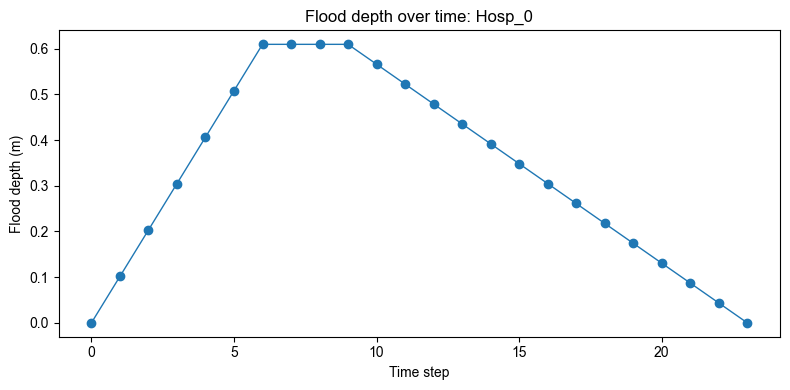

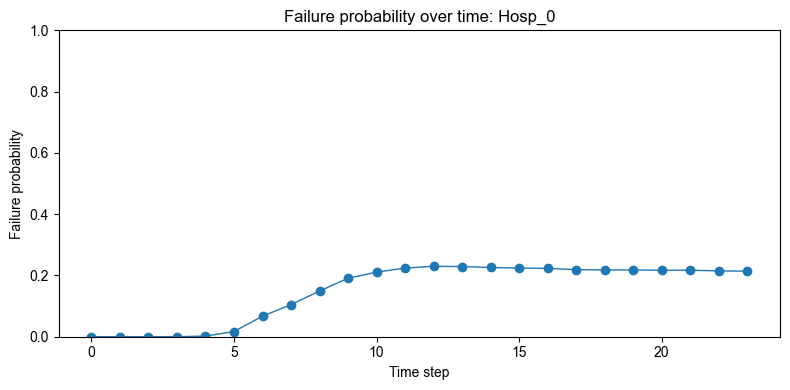

In [247]:
def plot_depth_and_fail(depths_series, p_fail, node="Hosp_0", title=None):
    T = len(depths_series)
    t = np.arange(T)

    depth = np.array([depths_series[tt].get(node, np.nan) for tt in range(T)], dtype=float)
    fail  = np.array([p_fail[tt].get(node, np.nan) for tt in range(T)], dtype=float)

    plt.figure(figsize=(8, 4))
    plt.plot(t, depth, marker="o", linewidth=1)
    plt.xlabel("Time step")
    plt.ylabel("Flood depth (m)")
    plt.title(title or f"Flood depth over time: {node}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(t, fail, marker="o", linewidth=1)
    plt.ylim(0, 1)
    plt.xlabel("Time step")
    plt.ylabel("Failure probability")
    plt.title(title or f"Failure probability over time: {node}")
    plt.tight_layout()
    plt.show()

plot_depth_and_fail(depths_series, p_fail, node="Hosp_0")